## $Amgoth Pavan Kumar$


# Training of Deep Neural Network for Wetland Vegetation Classification

### Designing and training a fully-connected deep neural network for the classification of wetland vegetation using hyperspectral imagery from the Kennedy Space Centre dataset in Florida.

### Description of Classes

| Label | Class            | Samples |
|-------|------------------|---------|
| 1     | Oak Hammock      | 229     |
| 2     | Mud Flats        | 503     |
| 3     | Spartina Marsh   | 520     |
| 4     | Salt Marsh       | 419     |
| 5     | Scrub            | 761     |
| 6     | CP/Oak Hammock   | 252     |
| 7     | CP Hammock       | 256     |
| 8     | Typha Marsh      | 404     |
| 9     | Willow Swamp     | 243     |
| 10    | Hardwood Swamp   | 105     |
| 11    | Graminoid Marsh  | 431     |
| 12    | Slash Pine       | 161     |
| 13    | Water Body       | 927     |


* There are 13 classes and samples corresponding to them, the data first normalized based on the minimum and maximum pixel values to compute them into reflectance.

* After normalizing the dataset, the arrays transposed for taking training and testing data

* Designed a fully-connected Deep Neural Network architectire which is suitable for classification of wetland vegetation classification by utilizing ADAM optimizer and cross entropy loss functions.

### Comparision of Classification Accuray of Activation Functions

* For Learning rate: (LR) 0.001 & 0.01

| Activation | Hidden_size  |  Num_layers|  Epochs | Accuracy (0.001) |Accuracy (0.01) |
|------------|--------------|------------|---------|------------------|----------------|
| ReLu       |64            |1           |10       |68.67%            |85.80%          |
|            |64            |2           |10       |72.95%            |82.35%          |
|            |64            |1           |100      |87.34             |89.45%          |
|            |64            |2           |100      |89.258%           |87.85%          |
|            |128           |3           |100      |91.24%            |90.72%          |
|            |256           |4           |1000     |93.24%            |92.58%
|--------------------------------------------------------------------------------------|
| LeakyReLu  |64            |1           |10       |71.80%            |82.09%          |
|            |64            |2           |10       |73.273%           |80.50%          |
|            |64            |1           |100      |89.58%            |89.07%          |
|            |64            |2           |100      |90.35%            |90.54%          |
|            |128           |3           |100      |92.26%            |83.63%          |
|            |256           |4           |1000     |93.61%            |87.78%
|--------------------------------------------------------------------------------------|
| Sigmoid    |64            |1           |10       |58.82             |80.37%          |
|            |64            |2           |10       |62.915%           |79.156%         |
|            |64            |1           |100      |86.95%            |92.26%          |
|            |64            |2           |100      |84.271%           |92.51%          |
|            |128           |3           |100      |86.70%            |86.32%          |
|            |256           |4           |1000     |92.52%            |91.68%

* After training the deep neural network the above are the results of different activation functions for different learning rates.

* From the above table it is clear that for learning rate = 0.01, the accuracy is high compare to the learning ratio = 0.001 for lesser hidden size, as your hidden size increases the accuracy for the learning rate = 0.01 becomes lesser than than accuracy of the learning rate = 0.001.

* For lower learning rate, accuracy is high for the high number of hidden layers, high width of layers and more epochs. For learning rate = 0.01 , accuracy is less as the width of layers and number of hidden layers increases.

* It is evident that for any learning rate as the epochs increases the classification accuracy increases for each activation function. From the above table LeakyReLU activation gave high classification accuracy compared to ReLU and Sigmoid activation functions for lower learning rate.


* For higher learning rate ReLU activation gave the higher classification accuracy compared to LeakyReLU and Sigmoid activation functions. 

* As the epochs (iterations) increases the accuracy increases for every case and also the number of layers increases the accuracy is also but when the hidden layer and epochs are constant and increase the number of layers till at point the accuracy increases but after the accuracy of classification decreases gradually. Based on this we'll choose the optimize number of layers for higher classification accuracy.`

### Importing all necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import ipywidgets as widgets
from IPython.display import display

### Loading the data

In [2]:
from scipy.io import loadmat

## Loading the spectra data
data = loadmat('gtspectra.mat')
data.keys()

dict_keys(['Oak Hammock', 'Mud Flats', 'Spartina Marsh', 'Salt Marsh', 'Scrub', 'CP/Oak Hammock', 'CP Hammock', 'Typha Marsh', 'Willow Swamp', 'Hardwood Swamp', 'Graminoid Marsh', 'Slash Pine', 'Water Body'])

In [3]:
#coverting the dataset into dataframe
data_df = {class_name: pd.DataFrame(data[class_name]) for class_name in data.keys()}
list(data_df)

['Oak Hammock',
 'Mud Flats',
 'Spartina Marsh',
 'Salt Marsh',
 'Scrub',
 'CP/Oak Hammock',
 'CP Hammock',
 'Typha Marsh',
 'Willow Swamp',
 'Hardwood Swamp',
 'Graminoid Marsh',
 'Slash Pine',
 'Water Body']

### Plotting the spectral curves before normalizing

In [4]:
##Assigning the colors for each class
colors = ['red', 'brown', 'black', 'orange', 'purple', 'green', 'pink', 'gray', 'cyan', 'magenta','yellow', 'violet', 'blue' ]

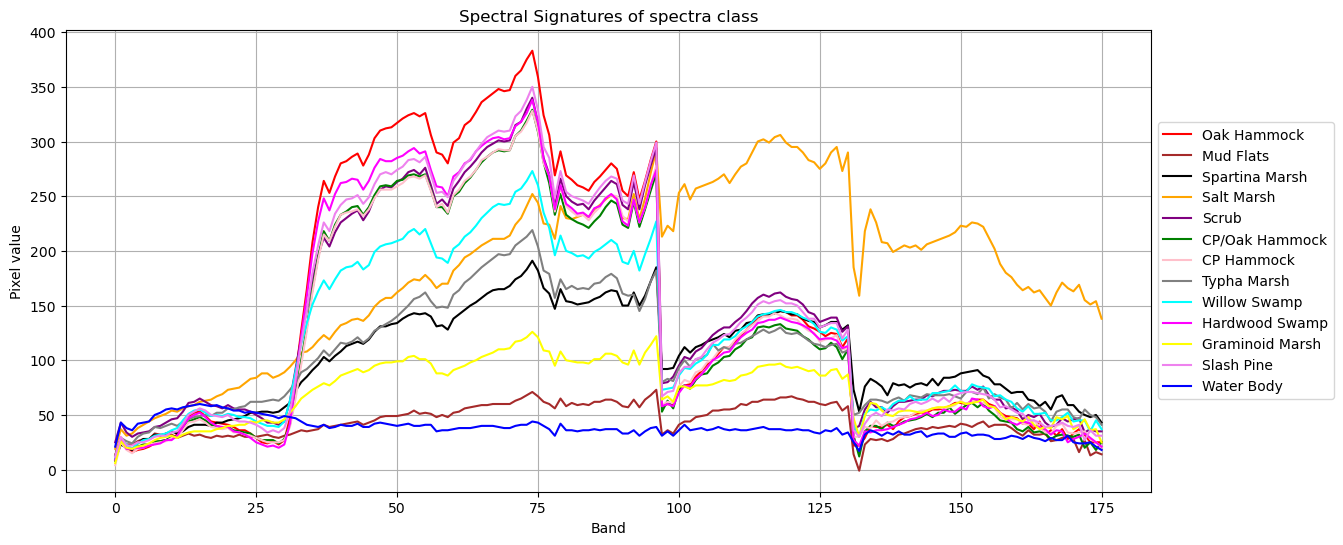

In [5]:
# Iterate over each class_name and plot the first 10 columns with individual colors
plt.figure(figsize=(14,6))
for i, (class_name, df) in enumerate(data_df.items()):
    color_index = i % len(colors)  # Calculate the index to ensure cycling through colors
    plt.plot(df.iloc[:, :1], color=colors[color_index], label=class_name)
    plt.title('Spectral Signatures of spectra class')
    plt.xlabel('Band')
    plt.ylabel('Pixel value')
    plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Normalizing the data

In [6]:
## Normalizing the data
max_reflectance = np.max([np.max(value) for value in data.values()])
min_reflectance = np.min([np.min(value) for value in data.values()])
print(max_reflectance, ',', min_reflectance)

414 , -11


In [7]:
## Storing the normalizing data
norm_data = {}
for key, value in data.items():
    norm_values = (value-min_reflectance)/(max_reflectance-min_reflectance)
    norm_data[key] = norm_values
#norm_data.keys()

In [8]:
#coverting the dataset into dataframe
norm_df = {class_name: pd.DataFrame(norm_data[class_name]) for class_name in norm_data.keys()}
#list(norm_df)
norm_df

{'Oak Hammock':           0         1         2         3         4         5         6    \
 0    0.056471  0.061176  0.056471  0.056471  0.070588  0.049412  0.061176   
 1    0.094118  0.094118  0.108235  0.096471  0.101176  0.096471  0.101176   
 2    0.072941  0.075294  0.077647  0.075294  0.072941  0.075294  0.077647   
 3    0.063529  0.072941  0.070588  0.068235  0.068235  0.061176  0.065882   
 4    0.068235  0.075294  0.075294  0.075294  0.077647  0.068235  0.070588   
 ..        ...       ...       ...       ...       ...       ...       ...   
 171  0.112941  0.101176  0.112941  0.094118  0.105882  0.087059  0.101176   
 172  0.101176  0.110588  0.117647  0.094118  0.110588  0.101176  0.117647   
 173  0.084706  0.091765  0.098824  0.108235  0.091765  0.091765  0.091765   
 174  0.084706  0.110588  0.117647  0.096471  0.091765  0.084706  0.084706   
 175  0.084706  0.084706  0.098824  0.091765  0.084706  0.091765  0.082353   
 
           7         8         9    ...       2

### Plotting the spectral curves after normalizing

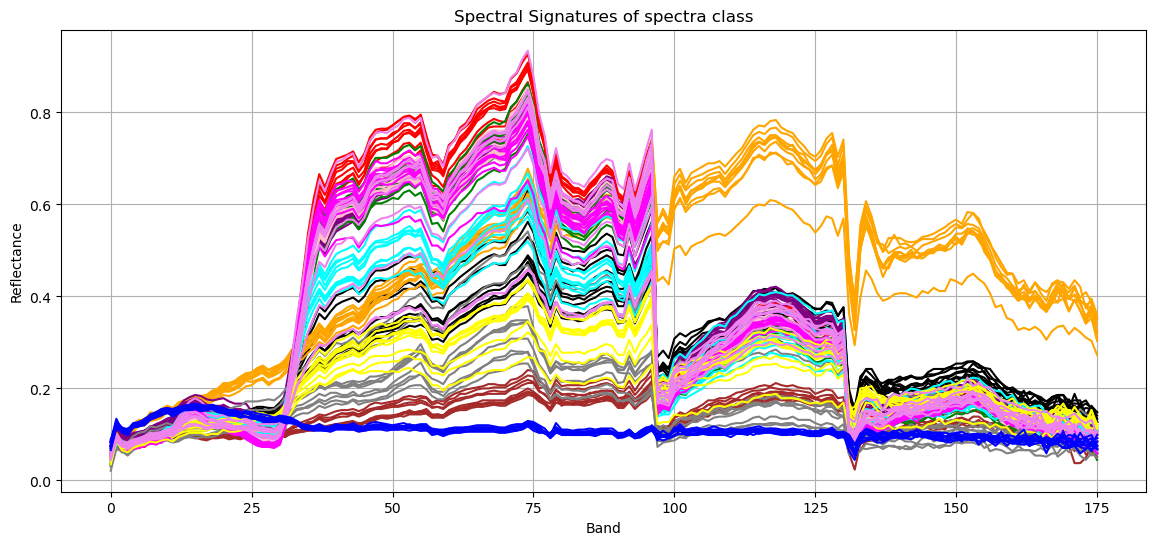

In [9]:
# Iterate over each class_name and plot the first 10 columns with individual colors
plt.figure(figsize=(14,6))
for i, (class_name, df) in enumerate(norm_df.items()):
    color_index = i % len(colors)  # Calculate the index to ensure cycling through colors
    plt.plot(df.iloc[:, :10], color=colors[color_index], label=class_name)
    plt.title('Spectral Signatures of spectra class')
    plt.xlabel('Band')
    plt.ylabel('Reflectance')
    plt.grid(True)

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Training the Deep Neural Network

In [10]:
#Assigning the X and y values 
keys = list(norm_df.keys())
print(keys)

X = np.concatenate([array.T for array in norm_data.values()], axis = 0)
y = np.arange(13)
repeat_counts = []

for i in range(len(keys)):
    repeat_counts.append(norm_df[keys[i]].shape[1])
    
#Repeat each element in y
repeat_y = [item for item, count in zip(y, repeat_counts) for i in range(count)]
y_data = np.array(repeat_y)

print('\nX shape:',X.shape, '\ny shape:', y_data.shape)

['Oak Hammock', 'Mud Flats', 'Spartina Marsh', 'Salt Marsh', 'Scrub', 'CP/Oak Hammock', 'CP Hammock', 'Typha Marsh', 'Willow Swamp', 'Hardwood Swamp', 'Graminoid Marsh', 'Slash Pine', 'Water Body']

X shape: (5211, 176) 
y shape: (5211,)


## Designing a Deep Neural Network Architecture

In [11]:
# Define the deep neural network architecture
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, activation):
        super(MyModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(activation)
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)
        layers.append(nn.Linear(hidden_size, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Using Relu Activation Function

In [12]:
# Defining the training function
def train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Create the model
    model = MyModel(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=num_layers,
                    num_classes=len(np.unique(y_train)), activation=activation)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # Training loop
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

    print("Training finished.")
    
    # Evaluation the testing data
    print(model.eval())
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted_y = torch.max(outputs, 1)
        accuracy = accuracy_score(y_test, predicted_y.numpy())
        print(f"Accuracy: {accuracy*100:.2f}%")
        
        #Printing the classified data
        print('Predicted Labels:')
        print(predicted_y.numpy())
        
        #Printing the actual labels
        print('Actual Labels:')
        print(y_test)
        
        #Print the accuracy
        print(f"Accuracy: {accuracy*100} %")
        
        # Plot y_test and predicted_y values
        plt.figure(figsize=(10, 4))
        plt.plot(y_test[:10], label='Actual')
        plt.plot(predicted_y.numpy()[:10], label='Predicted')
        plt.xlabel('Sample')
        plt.ylabel('Class')
        plt.title('Actual vs Predicted Labels')
        plt.legend()
        plt.grid(True)
        plt.show()

### Setting 1, Epochs = 10 for Layer = 1, hidden_layer = 64

Epoch [1/10], Average Loss: 2.3506
Epoch [2/10], Average Loss: 1.9720
Epoch [3/10], Average Loss: 1.6309
Epoch [4/10], Average Loss: 1.4161
Epoch [5/10], Average Loss: 1.2884
Epoch [6/10], Average Loss: 1.1977
Epoch [7/10], Average Loss: 1.1269
Epoch [8/10], Average Loss: 1.0722
Epoch [9/10], Average Loss: 1.0248
Epoch [10/10], Average Loss: 0.9906
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 68.67%
Predicted Labels:
[4 2 6 ... 4 2 6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 68.67007672634271 %


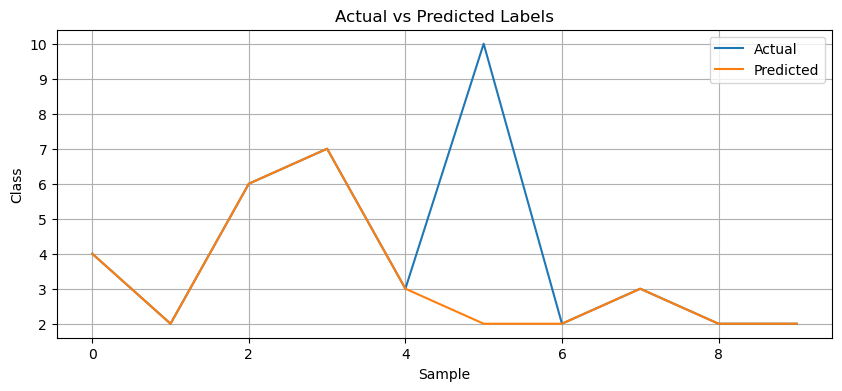

In [13]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.ReLU()
learning_rate = 0.001
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/10], Average Loss: 1.6338
Epoch [2/10], Average Loss: 1.0159
Epoch [3/10], Average Loss: 0.8783
Epoch [4/10], Average Loss: 0.7974
Epoch [5/10], Average Loss: 0.7432
Epoch [6/10], Average Loss: 0.7079
Epoch [7/10], Average Loss: 0.6169
Epoch [8/10], Average Loss: 0.5557
Epoch [9/10], Average Loss: 0.5299
Epoch [10/10], Average Loss: 0.5255
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 85.81%
Predicted Labels:
[ 4  2  6 ...  8 10  6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 85.80562659846548 %


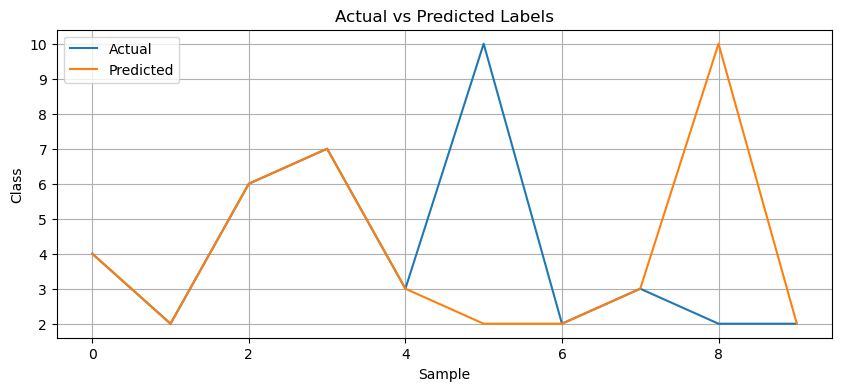

In [58]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.ReLU()
learning_rate = 0.01
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

*  For Epochs = 10 and num_layers = 1 for 64 neurons, the accuracy is 70.78 % it is quite good classification for 10 iterations using the Relu activation.

###  Setting 2 Epochs = 10 for Layer = 2, hidden_layer = 64

Epoch [1/10], Average Loss: 2.3680
Epoch [2/10], Average Loss: 1.6547
Epoch [3/10], Average Loss: 1.2279
Epoch [4/10], Average Loss: 1.0548
Epoch [5/10], Average Loss: 0.9580
Epoch [6/10], Average Loss: 0.9093
Epoch [7/10], Average Loss: 0.8634
Epoch [8/10], Average Loss: 0.8335
Epoch [9/10], Average Loss: 0.8168
Epoch [10/10], Average Loss: 0.7824
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 72.95%
Predicted Labels:
[ 4  2  6 ...  4 10  6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 72.9539641943734 %


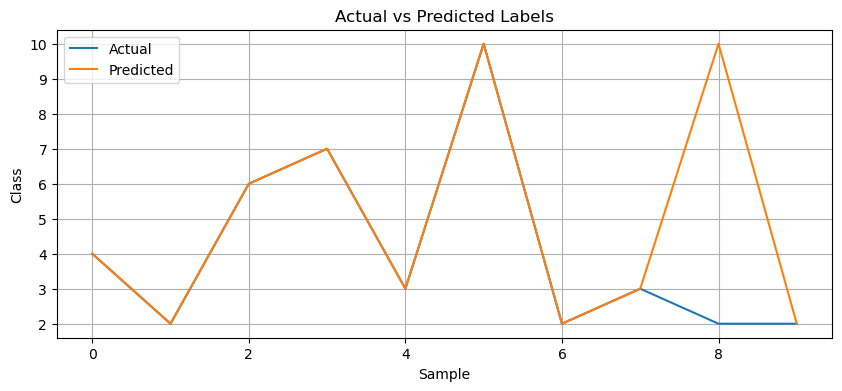

In [14]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.ReLU()
learning_rate = 0.001
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/10], Average Loss: 1.5678
Epoch [2/10], Average Loss: 0.9464
Epoch [3/10], Average Loss: 0.8448
Epoch [4/10], Average Loss: 0.7940
Epoch [5/10], Average Loss: 0.7173
Epoch [6/10], Average Loss: 0.7914
Epoch [7/10], Average Loss: 0.6872
Epoch [8/10], Average Loss: 0.6578
Epoch [9/10], Average Loss: 0.6284
Epoch [10/10], Average Loss: 0.5993
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 82.35%
Predicted Labels:
[ 4  2  6 ...  8 10  6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 82.35294117647058 %


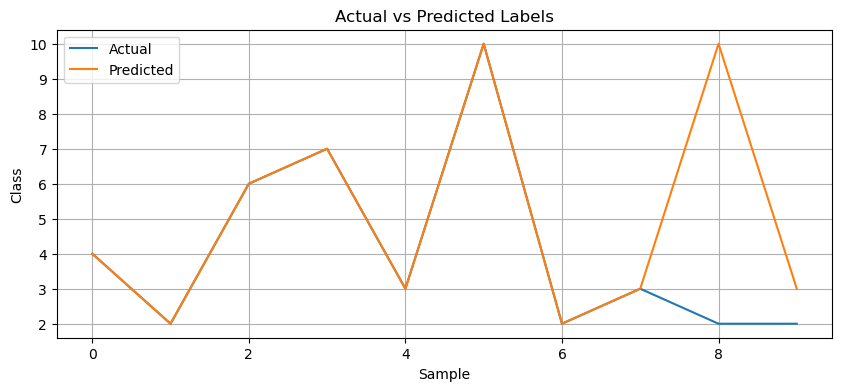

In [59]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.ReLU()
learning_rate = 0.01
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 3 Epochs = 100 for Layer = 1, hidden_layer = 64

Epoch [1/100], Average Loss: 2.3439
Epoch [2/100], Average Loss: 1.9281
Epoch [3/100], Average Loss: 1.5771
Epoch [4/100], Average Loss: 1.3809
Epoch [5/100], Average Loss: 1.2623
Epoch [6/100], Average Loss: 1.1722
Epoch [7/100], Average Loss: 1.1033
Epoch [8/100], Average Loss: 1.0518
Epoch [9/100], Average Loss: 1.0031
Epoch [10/100], Average Loss: 0.9684
Epoch [11/100], Average Loss: 0.9336
Epoch [12/100], Average Loss: 0.9056
Epoch [13/100], Average Loss: 0.8853
Epoch [14/100], Average Loss: 0.8636
Epoch [15/100], Average Loss: 0.8409
Epoch [16/100], Average Loss: 0.8243
Epoch [17/100], Average Loss: 0.8039
Epoch [18/100], Average Loss: 0.7904
Epoch [19/100], Average Loss: 0.7769
Epoch [20/100], Average Loss: 0.7717
Epoch [21/100], Average Loss: 0.7544
Epoch [22/100], Average Loss: 0.7353
Epoch [23/100], Average Loss: 0.7224
Epoch [24/100], Average Loss: 0.7122
Epoch [25/100], Average Loss: 0.6965
Epoch [26/100], Average Loss: 0.6950
Epoch [27/100], Average Loss: 0.6788
Epoch [28/

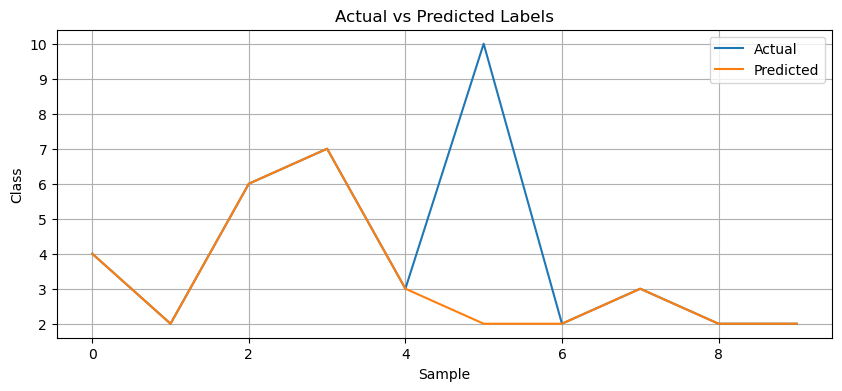

In [15]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.ReLU()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 1.5552
Epoch [2/100], Average Loss: 0.9973
Epoch [3/100], Average Loss: 0.8690
Epoch [4/100], Average Loss: 0.7935
Epoch [5/100], Average Loss: 0.7569
Epoch [6/100], Average Loss: 0.6808
Epoch [7/100], Average Loss: 0.6409
Epoch [8/100], Average Loss: 0.5829
Epoch [9/100], Average Loss: 0.5514
Epoch [10/100], Average Loss: 0.5259
Epoch [11/100], Average Loss: 0.5167
Epoch [12/100], Average Loss: 0.4964
Epoch [13/100], Average Loss: 0.4621
Epoch [14/100], Average Loss: 0.4450
Epoch [15/100], Average Loss: 0.4591
Epoch [16/100], Average Loss: 0.4139
Epoch [17/100], Average Loss: 0.4267
Epoch [18/100], Average Loss: 0.4203
Epoch [19/100], Average Loss: 0.4304
Epoch [20/100], Average Loss: 0.4222
Epoch [21/100], Average Loss: 0.3860
Epoch [22/100], Average Loss: 0.3900
Epoch [23/100], Average Loss: 0.3871
Epoch [24/100], Average Loss: 0.3695
Epoch [25/100], Average Loss: 0.3737
Epoch [26/100], Average Loss: 0.3483
Epoch [27/100], Average Loss: 0.3729
Epoch [28/

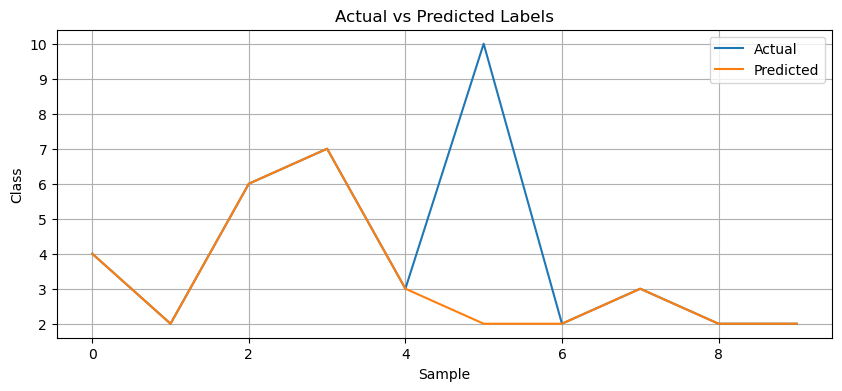

In [60]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.ReLU()
learning_rate = 0.01
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 4, Epochs = 100 for Layer = 2, hidden_layer = 64

Epoch [1/100], Average Loss: 2.3715
Epoch [2/100], Average Loss: 1.6804
Epoch [3/100], Average Loss: 1.2537
Epoch [4/100], Average Loss: 1.0788
Epoch [5/100], Average Loss: 0.9762
Epoch [6/100], Average Loss: 0.9252
Epoch [7/100], Average Loss: 0.8897
Epoch [8/100], Average Loss: 0.8526
Epoch [9/100], Average Loss: 0.8256
Epoch [10/100], Average Loss: 0.8198
Epoch [11/100], Average Loss: 0.7919
Epoch [12/100], Average Loss: 0.7742
Epoch [13/100], Average Loss: 0.7548
Epoch [14/100], Average Loss: 0.7536
Epoch [15/100], Average Loss: 0.7386
Epoch [16/100], Average Loss: 0.7327
Epoch [17/100], Average Loss: 0.7191
Epoch [18/100], Average Loss: 0.7103
Epoch [19/100], Average Loss: 0.6972
Epoch [20/100], Average Loss: 0.6884
Epoch [21/100], Average Loss: 0.6848
Epoch [22/100], Average Loss: 0.6653
Epoch [23/100], Average Loss: 0.6642
Epoch [24/100], Average Loss: 0.6504
Epoch [25/100], Average Loss: 0.6425
Epoch [26/100], Average Loss: 0.6322
Epoch [27/100], Average Loss: 0.6275
Epoch [28/

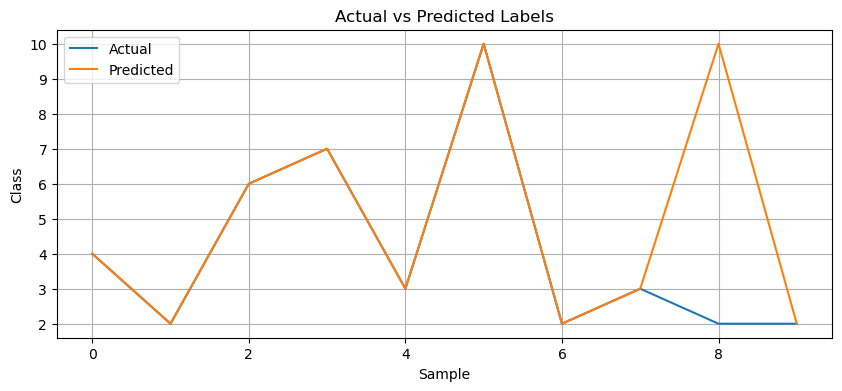

In [16]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.ReLU()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 1.4284
Epoch [2/100], Average Loss: 0.9026
Epoch [3/100], Average Loss: 0.8078
Epoch [4/100], Average Loss: 0.7840
Epoch [5/100], Average Loss: 0.7226
Epoch [6/100], Average Loss: 0.7562
Epoch [7/100], Average Loss: 0.6273
Epoch [8/100], Average Loss: 0.5686
Epoch [9/100], Average Loss: 0.5180
Epoch [10/100], Average Loss: 0.4398
Epoch [11/100], Average Loss: 0.4776
Epoch [12/100], Average Loss: 0.4219
Epoch [13/100], Average Loss: 0.4338
Epoch [14/100], Average Loss: 0.4303
Epoch [15/100], Average Loss: 0.4194
Epoch [16/100], Average Loss: 0.4218
Epoch [17/100], Average Loss: 0.4050
Epoch [18/100], Average Loss: 0.4104
Epoch [19/100], Average Loss: 0.4088
Epoch [20/100], Average Loss: 0.3696
Epoch [21/100], Average Loss: 0.3658
Epoch [22/100], Average Loss: 0.3740
Epoch [23/100], Average Loss: 0.3635
Epoch [24/100], Average Loss: 0.3664
Epoch [25/100], Average Loss: 0.3624
Epoch [26/100], Average Loss: 0.3372
Epoch [27/100], Average Loss: 0.3309
Epoch [28/

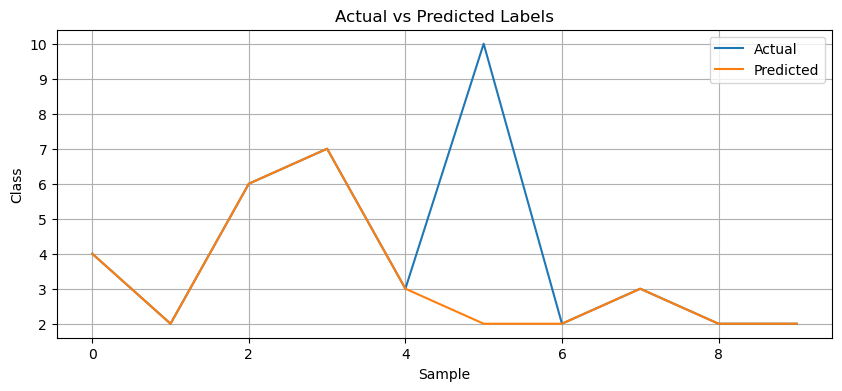

In [61]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.ReLU()
learning_rate = 0.01
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 5, Epochs = 100 for Layer = 3, hidden_layer = 128

Epoch [1/100], Average Loss: 2.1291
Epoch [2/100], Average Loss: 1.1361
Epoch [3/100], Average Loss: 0.9497
Epoch [4/100], Average Loss: 0.8708
Epoch [5/100], Average Loss: 0.8285
Epoch [6/100], Average Loss: 0.8003
Epoch [7/100], Average Loss: 0.7710
Epoch [8/100], Average Loss: 0.7331
Epoch [9/100], Average Loss: 0.7499
Epoch [10/100], Average Loss: 0.7121
Epoch [11/100], Average Loss: 0.6982
Epoch [12/100], Average Loss: 0.6751
Epoch [13/100], Average Loss: 0.6704
Epoch [14/100], Average Loss: 0.6459
Epoch [15/100], Average Loss: 0.6397
Epoch [16/100], Average Loss: 0.6477
Epoch [17/100], Average Loss: 0.6477
Epoch [18/100], Average Loss: 0.6388
Epoch [19/100], Average Loss: 0.6116
Epoch [20/100], Average Loss: 0.6177
Epoch [21/100], Average Loss: 0.6178
Epoch [22/100], Average Loss: 0.6308
Epoch [23/100], Average Loss: 0.5840
Epoch [24/100], Average Loss: 0.5992
Epoch [25/100], Average Loss: 0.5838
Epoch [26/100], Average Loss: 0.5766
Epoch [27/100], Average Loss: 0.5788
Epoch [28/

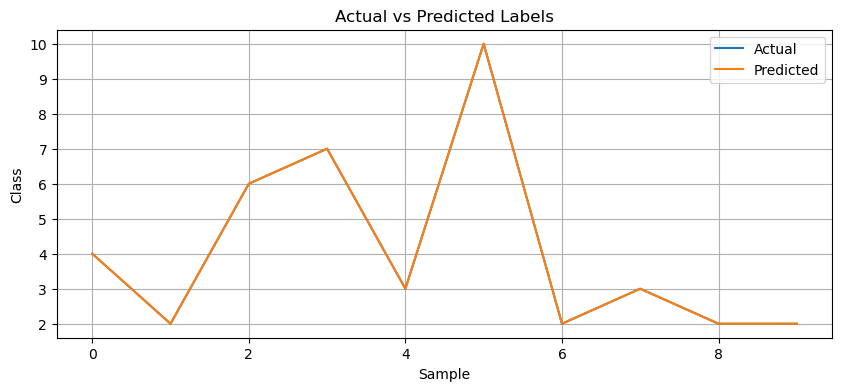

In [17]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 128
num_layers = 3
activation = nn.ReLU()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 1.5274
Epoch [2/100], Average Loss: 1.0246
Epoch [3/100], Average Loss: 0.8656
Epoch [4/100], Average Loss: 0.8187
Epoch [5/100], Average Loss: 0.7831
Epoch [6/100], Average Loss: 0.7486
Epoch [7/100], Average Loss: 0.6912
Epoch [8/100], Average Loss: 0.7148
Epoch [9/100], Average Loss: 0.6142
Epoch [10/100], Average Loss: 0.6259
Epoch [11/100], Average Loss: 0.5673
Epoch [12/100], Average Loss: 0.5291
Epoch [13/100], Average Loss: 0.5803
Epoch [14/100], Average Loss: 0.4960
Epoch [15/100], Average Loss: 0.4837
Epoch [16/100], Average Loss: 0.4764
Epoch [17/100], Average Loss: 0.4152
Epoch [18/100], Average Loss: 0.5851
Epoch [19/100], Average Loss: 0.4810
Epoch [20/100], Average Loss: 0.4570
Epoch [21/100], Average Loss: 0.3977
Epoch [22/100], Average Loss: 0.5439
Epoch [23/100], Average Loss: 0.4029
Epoch [24/100], Average Loss: 0.3929
Epoch [25/100], Average Loss: 0.5017
Epoch [26/100], Average Loss: 0.3673
Epoch [27/100], Average Loss: 0.4208
Epoch [28/

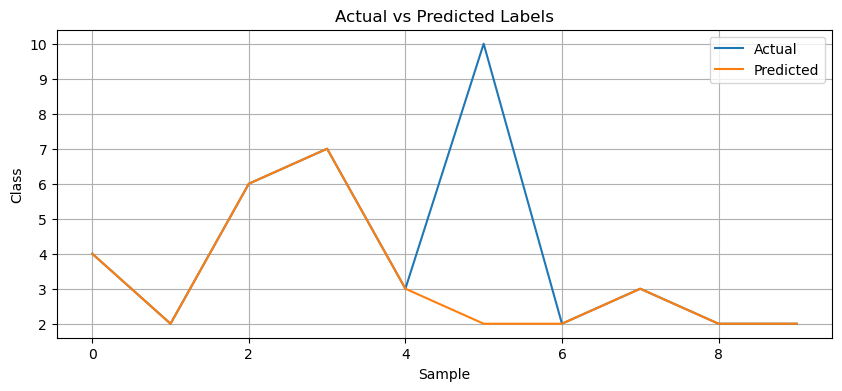

In [62]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 128
num_layers = 3
activation = nn.ReLU()
learning_rate = 0.01
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 6, Epochs = 1000 for Layer = 4, hidden_layer = 256

Epoch [1/1000], Average Loss: 1.7593
Epoch [2/1000], Average Loss: 1.0355
Epoch [3/1000], Average Loss: 0.8729
Epoch [4/1000], Average Loss: 0.7892
Epoch [5/1000], Average Loss: 0.7956
Epoch [6/1000], Average Loss: 0.7398
Epoch [7/1000], Average Loss: 0.7784
Epoch [8/1000], Average Loss: 0.7033
Epoch [9/1000], Average Loss: 0.7131
Epoch [10/1000], Average Loss: 0.7243
Epoch [11/1000], Average Loss: 0.6666
Epoch [12/1000], Average Loss: 0.6903
Epoch [13/1000], Average Loss: 0.6716
Epoch [14/1000], Average Loss: 0.6622
Epoch [15/1000], Average Loss: 0.6385
Epoch [16/1000], Average Loss: 0.6139
Epoch [17/1000], Average Loss: 0.6553
Epoch [18/1000], Average Loss: 0.6456
Epoch [19/1000], Average Loss: 0.5938
Epoch [20/1000], Average Loss: 0.6131
Epoch [21/1000], Average Loss: 0.5956
Epoch [22/1000], Average Loss: 0.6204
Epoch [23/1000], Average Loss: 0.5793
Epoch [24/1000], Average Loss: 0.6095
Epoch [25/1000], Average Loss: 0.5367
Epoch [26/1000], Average Loss: 0.5371
Epoch [27/1000], Aver

Epoch [214/1000], Average Loss: 0.1885
Epoch [215/1000], Average Loss: 0.1485
Epoch [216/1000], Average Loss: 0.1907
Epoch [217/1000], Average Loss: 0.1553
Epoch [218/1000], Average Loss: 0.1527
Epoch [219/1000], Average Loss: 0.1587
Epoch [220/1000], Average Loss: 0.1892
Epoch [221/1000], Average Loss: 0.1636
Epoch [222/1000], Average Loss: 0.1883
Epoch [223/1000], Average Loss: 0.1571
Epoch [224/1000], Average Loss: 0.1904
Epoch [225/1000], Average Loss: 0.1966
Epoch [226/1000], Average Loss: 0.2488
Epoch [227/1000], Average Loss: 0.1564
Epoch [228/1000], Average Loss: 0.1597
Epoch [229/1000], Average Loss: 0.1464
Epoch [230/1000], Average Loss: 0.2080
Epoch [231/1000], Average Loss: 0.2077
Epoch [232/1000], Average Loss: 0.2159
Epoch [233/1000], Average Loss: 0.1979
Epoch [234/1000], Average Loss: 0.1598
Epoch [235/1000], Average Loss: 0.1504
Epoch [236/1000], Average Loss: 0.1408
Epoch [237/1000], Average Loss: 0.1426
Epoch [238/1000], Average Loss: 0.1529
Epoch [239/1000], Average

Epoch [425/1000], Average Loss: 0.1106
Epoch [426/1000], Average Loss: 0.1192
Epoch [427/1000], Average Loss: 0.1671
Epoch [428/1000], Average Loss: 0.0982
Epoch [429/1000], Average Loss: 0.1032
Epoch [430/1000], Average Loss: 0.0879
Epoch [431/1000], Average Loss: 0.1295
Epoch [432/1000], Average Loss: 0.1791
Epoch [433/1000], Average Loss: 0.1118
Epoch [434/1000], Average Loss: 0.1258
Epoch [435/1000], Average Loss: 0.1369
Epoch [436/1000], Average Loss: 0.1231
Epoch [437/1000], Average Loss: 0.1015
Epoch [438/1000], Average Loss: 0.1095
Epoch [439/1000], Average Loss: 0.0907
Epoch [440/1000], Average Loss: 0.1100
Epoch [441/1000], Average Loss: 0.0879
Epoch [442/1000], Average Loss: 0.1343
Epoch [443/1000], Average Loss: 0.1308
Epoch [444/1000], Average Loss: 0.1114
Epoch [445/1000], Average Loss: 0.0989
Epoch [446/1000], Average Loss: 0.0856
Epoch [447/1000], Average Loss: 0.1174
Epoch [448/1000], Average Loss: 0.0919
Epoch [449/1000], Average Loss: 0.0951
Epoch [450/1000], Average

Epoch [636/1000], Average Loss: 0.0770
Epoch [637/1000], Average Loss: 0.0707
Epoch [638/1000], Average Loss: 0.0878
Epoch [639/1000], Average Loss: 0.0678
Epoch [640/1000], Average Loss: 0.0709
Epoch [641/1000], Average Loss: 0.0798
Epoch [642/1000], Average Loss: 0.0572
Epoch [643/1000], Average Loss: 0.0529
Epoch [644/1000], Average Loss: 0.0666
Epoch [645/1000], Average Loss: 0.0881
Epoch [646/1000], Average Loss: 0.0686
Epoch [647/1000], Average Loss: 0.0558
Epoch [648/1000], Average Loss: 0.0816
Epoch [649/1000], Average Loss: 0.1134
Epoch [650/1000], Average Loss: 0.0736
Epoch [651/1000], Average Loss: 0.0953
Epoch [652/1000], Average Loss: 0.1303
Epoch [653/1000], Average Loss: 0.0629
Epoch [654/1000], Average Loss: 0.0641
Epoch [655/1000], Average Loss: 0.0571
Epoch [656/1000], Average Loss: 0.0692
Epoch [657/1000], Average Loss: 0.1807
Epoch [658/1000], Average Loss: 0.0754
Epoch [659/1000], Average Loss: 0.0616
Epoch [660/1000], Average Loss: 0.0603
Epoch [661/1000], Average

Epoch [847/1000], Average Loss: 0.0390
Epoch [848/1000], Average Loss: 0.0293
Epoch [849/1000], Average Loss: 0.0581
Epoch [850/1000], Average Loss: 0.0677
Epoch [851/1000], Average Loss: 0.0519
Epoch [852/1000], Average Loss: 0.0679
Epoch [853/1000], Average Loss: 0.0800
Epoch [854/1000], Average Loss: 0.0638
Epoch [855/1000], Average Loss: 0.1267
Epoch [856/1000], Average Loss: 0.0878
Epoch [857/1000], Average Loss: 0.0522
Epoch [858/1000], Average Loss: 0.0529
Epoch [859/1000], Average Loss: 0.0587
Epoch [860/1000], Average Loss: 0.0943
Epoch [861/1000], Average Loss: 0.0555
Epoch [862/1000], Average Loss: 0.0351
Epoch [863/1000], Average Loss: 0.0362
Epoch [864/1000], Average Loss: 0.0539
Epoch [865/1000], Average Loss: 0.0822
Epoch [866/1000], Average Loss: 0.0528
Epoch [867/1000], Average Loss: 0.0778
Epoch [868/1000], Average Loss: 0.0417
Epoch [869/1000], Average Loss: 0.1456
Epoch [870/1000], Average Loss: 0.0677
Epoch [871/1000], Average Loss: 0.0418
Epoch [872/1000], Average

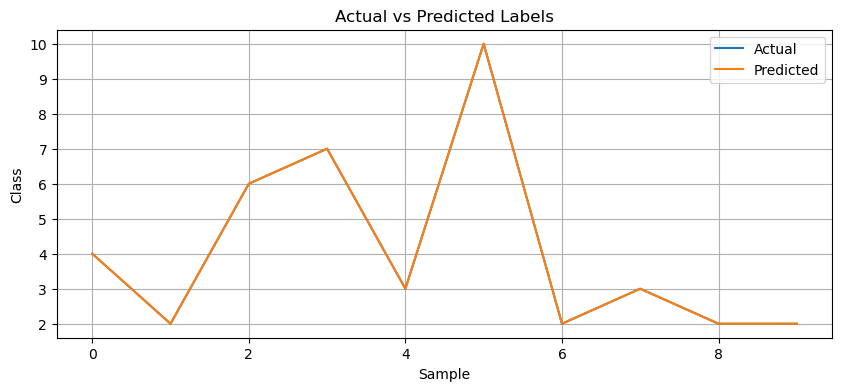

In [18]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 256
num_layers = 4
activation = nn.ReLU()
learning_rate = 0.001
epochs = 1000

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/1000], Average Loss: 1.6976
Epoch [2/1000], Average Loss: 1.0508
Epoch [3/1000], Average Loss: 0.9583
Epoch [4/1000], Average Loss: 1.0109
Epoch [5/1000], Average Loss: 0.8533
Epoch [6/1000], Average Loss: 0.7852
Epoch [7/1000], Average Loss: 0.7069
Epoch [8/1000], Average Loss: 0.8595
Epoch [9/1000], Average Loss: 0.7048
Epoch [10/1000], Average Loss: 0.7685
Epoch [11/1000], Average Loss: 0.6221
Epoch [12/1000], Average Loss: 0.6157
Epoch [13/1000], Average Loss: 0.5751
Epoch [14/1000], Average Loss: 0.6078
Epoch [15/1000], Average Loss: 0.5612
Epoch [16/1000], Average Loss: 0.5473
Epoch [17/1000], Average Loss: 0.5927
Epoch [18/1000], Average Loss: 0.5540
Epoch [19/1000], Average Loss: 0.6101
Epoch [20/1000], Average Loss: 0.5275
Epoch [21/1000], Average Loss: 0.5266
Epoch [22/1000], Average Loss: 0.4535
Epoch [23/1000], Average Loss: 0.4784
Epoch [24/1000], Average Loss: 0.4528
Epoch [25/1000], Average Loss: 0.5158
Epoch [26/1000], Average Loss: 0.5580
Epoch [27/1000], Aver

Epoch [214/1000], Average Loss: 0.2642
Epoch [215/1000], Average Loss: 0.2146
Epoch [216/1000], Average Loss: 0.1950
Epoch [217/1000], Average Loss: 0.2272
Epoch [218/1000], Average Loss: 0.2323
Epoch [219/1000], Average Loss: 0.2025
Epoch [220/1000], Average Loss: 0.3436
Epoch [221/1000], Average Loss: 0.2160
Epoch [222/1000], Average Loss: 0.2262
Epoch [223/1000], Average Loss: 0.2390
Epoch [224/1000], Average Loss: 0.2635
Epoch [225/1000], Average Loss: 0.2403
Epoch [226/1000], Average Loss: 0.2009
Epoch [227/1000], Average Loss: 0.2332
Epoch [228/1000], Average Loss: 0.2349
Epoch [229/1000], Average Loss: 0.2146
Epoch [230/1000], Average Loss: 0.1916
Epoch [231/1000], Average Loss: 0.2019
Epoch [232/1000], Average Loss: 0.2641
Epoch [233/1000], Average Loss: 0.2290
Epoch [234/1000], Average Loss: 0.1943
Epoch [235/1000], Average Loss: 0.2577
Epoch [236/1000], Average Loss: 0.2521
Epoch [237/1000], Average Loss: 0.2147
Epoch [238/1000], Average Loss: 0.2476
Epoch [239/1000], Average

Epoch [425/1000], Average Loss: 0.2398
Epoch [426/1000], Average Loss: 0.1832
Epoch [427/1000], Average Loss: 0.2082
Epoch [428/1000], Average Loss: 0.2004
Epoch [429/1000], Average Loss: 0.1881
Epoch [430/1000], Average Loss: 0.2000
Epoch [431/1000], Average Loss: 0.1825
Epoch [432/1000], Average Loss: 0.1664
Epoch [433/1000], Average Loss: 0.1920
Epoch [434/1000], Average Loss: 0.2731
Epoch [435/1000], Average Loss: 0.2268
Epoch [436/1000], Average Loss: 0.2305
Epoch [437/1000], Average Loss: 0.1764
Epoch [438/1000], Average Loss: 0.1848
Epoch [439/1000], Average Loss: 0.1935
Epoch [440/1000], Average Loss: 0.2385
Epoch [441/1000], Average Loss: 0.2216
Epoch [442/1000], Average Loss: 0.2012
Epoch [443/1000], Average Loss: 0.2117
Epoch [444/1000], Average Loss: 0.2599
Epoch [445/1000], Average Loss: 0.2120
Epoch [446/1000], Average Loss: 0.1893
Epoch [447/1000], Average Loss: 0.2207
Epoch [448/1000], Average Loss: 0.1854
Epoch [449/1000], Average Loss: 0.2257
Epoch [450/1000], Average

Epoch [636/1000], Average Loss: 0.1959
Epoch [637/1000], Average Loss: 0.1678
Epoch [638/1000], Average Loss: 0.1598
Epoch [639/1000], Average Loss: 0.1943
Epoch [640/1000], Average Loss: 0.1861
Epoch [641/1000], Average Loss: 0.2721
Epoch [642/1000], Average Loss: 0.1903
Epoch [643/1000], Average Loss: 0.1696
Epoch [644/1000], Average Loss: 0.1873
Epoch [645/1000], Average Loss: 0.1778
Epoch [646/1000], Average Loss: 0.2723
Epoch [647/1000], Average Loss: 0.1644
Epoch [648/1000], Average Loss: 0.1758
Epoch [649/1000], Average Loss: 0.1599
Epoch [650/1000], Average Loss: 0.1726
Epoch [651/1000], Average Loss: 0.2730
Epoch [652/1000], Average Loss: 0.2039
Epoch [653/1000], Average Loss: 0.2154
Epoch [654/1000], Average Loss: 0.2004
Epoch [655/1000], Average Loss: 0.1706
Epoch [656/1000], Average Loss: 0.1566
Epoch [657/1000], Average Loss: 0.1806
Epoch [658/1000], Average Loss: 0.1611
Epoch [659/1000], Average Loss: 0.1791
Epoch [660/1000], Average Loss: 0.1548
Epoch [661/1000], Average

Epoch [847/1000], Average Loss: 0.1805
Epoch [848/1000], Average Loss: 0.1777
Epoch [849/1000], Average Loss: 0.1756
Epoch [850/1000], Average Loss: 0.1559
Epoch [851/1000], Average Loss: 0.1677
Epoch [852/1000], Average Loss: 0.1517
Epoch [853/1000], Average Loss: 0.1764
Epoch [854/1000], Average Loss: 0.1648
Epoch [855/1000], Average Loss: 0.1754
Epoch [856/1000], Average Loss: 0.2160
Epoch [857/1000], Average Loss: 0.1774
Epoch [858/1000], Average Loss: 0.1725
Epoch [859/1000], Average Loss: 0.1495
Epoch [860/1000], Average Loss: 0.2373
Epoch [861/1000], Average Loss: 0.1984
Epoch [862/1000], Average Loss: 0.2050
Epoch [863/1000], Average Loss: 0.1696
Epoch [864/1000], Average Loss: 0.1459
Epoch [865/1000], Average Loss: 0.1456
Epoch [866/1000], Average Loss: 0.1393
Epoch [867/1000], Average Loss: 0.1796
Epoch [868/1000], Average Loss: 0.1631
Epoch [869/1000], Average Loss: 0.2096
Epoch [870/1000], Average Loss: 0.1663
Epoch [871/1000], Average Loss: 0.1795
Epoch [872/1000], Average

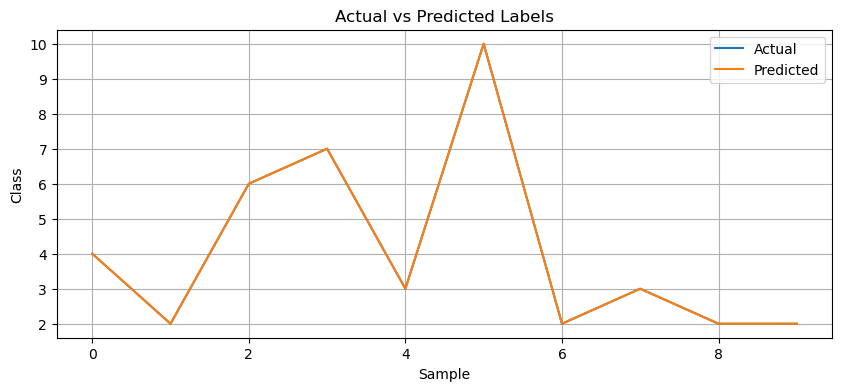

In [73]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 256
num_layers = 4
activation = nn.ReLU()
learning_rate = 0.01
epochs = 1000

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

## Leaky ReLU Activation Function

### Setting 1, num_layers = 1, epochs=10, hidden_size=64

Epoch [1/10], Average Loss: 2.3284
Epoch [2/10], Average Loss: 1.8771
Epoch [3/10], Average Loss: 1.4904
Epoch [4/10], Average Loss: 1.2881
Epoch [5/10], Average Loss: 1.1702
Epoch [6/10], Average Loss: 1.0818
Epoch [7/10], Average Loss: 1.0149
Epoch [8/10], Average Loss: 0.9674
Epoch [9/10], Average Loss: 0.9294
Epoch [10/10], Average Loss: 0.8948
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 71.80%
Predicted Labels:
[4 2 6 ... 4 2 6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 71.80306905370844 %


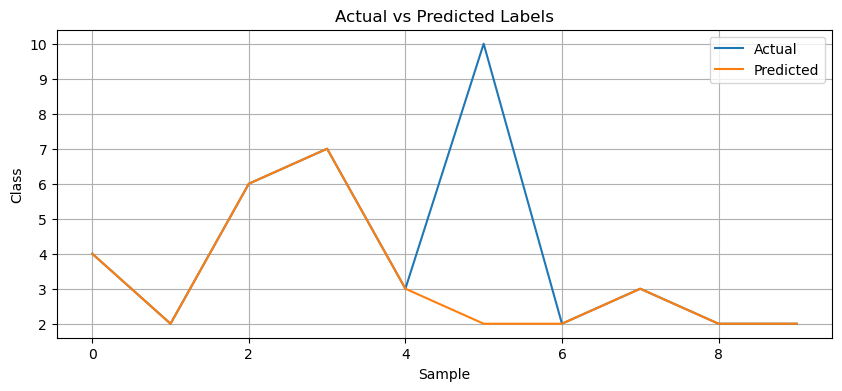

In [87]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.LeakyReLU()
learning_rate = 0.001
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/10], Average Loss: 1.5060
Epoch [2/10], Average Loss: 0.9556
Epoch [3/10], Average Loss: 0.8694
Epoch [4/10], Average Loss: 0.7727
Epoch [5/10], Average Loss: 0.7023
Epoch [6/10], Average Loss: 0.6668
Epoch [7/10], Average Loss: 0.5717
Epoch [8/10], Average Loss: 0.5455
Epoch [9/10], Average Loss: 0.5268
Epoch [10/10], Average Loss: 0.5216
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 82.10%
Predicted Labels:
[4 2 6 ... 8 2 6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 82.09718670076727 %


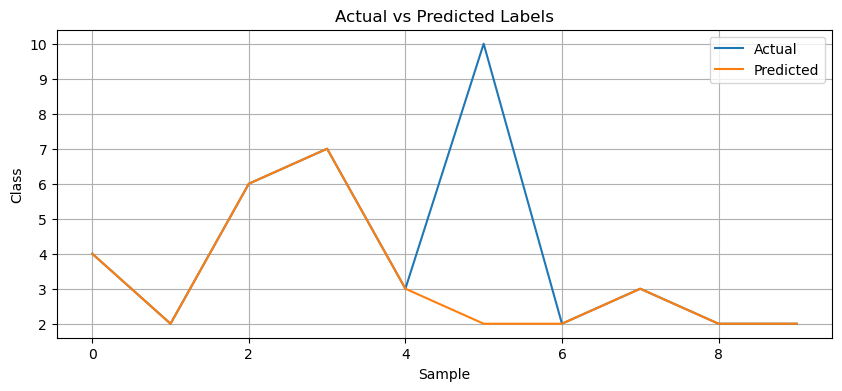

In [57]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.LeakyReLU()
learning_rate = 0.01
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 2, Epochs = 10 for Layer = 2, hidden_layer = 64

Epoch [1/10], Average Loss: 2.3351
Epoch [2/10], Average Loss: 1.6098
Epoch [3/10], Average Loss: 1.1614
Epoch [4/10], Average Loss: 1.0021
Epoch [5/10], Average Loss: 0.9141
Epoch [6/10], Average Loss: 0.8741
Epoch [7/10], Average Loss: 0.8314
Epoch [8/10], Average Loss: 0.8058
Epoch [9/10], Average Loss: 0.7874
Epoch [10/10], Average Loss: 0.7770
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 73.27%
Predicted Labels:
[ 4  2  6 ...  4 10  6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 73.27365728900256 %


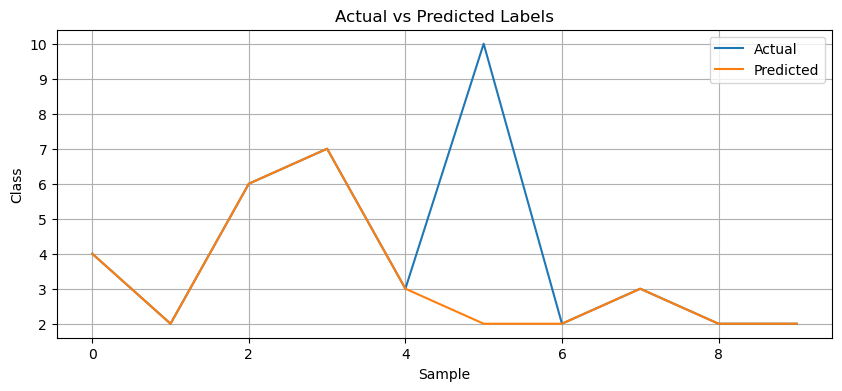

In [20]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.LeakyReLU()
learning_rate = 0.001
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/10], Average Loss: 1.4422
Epoch [2/10], Average Loss: 0.9161
Epoch [3/10], Average Loss: 0.8103
Epoch [4/10], Average Loss: 0.7885
Epoch [5/10], Average Loss: 0.7003
Epoch [6/10], Average Loss: 0.6674
Epoch [7/10], Average Loss: 0.6882
Epoch [8/10], Average Loss: 0.6338
Epoch [9/10], Average Loss: 0.5707
Epoch [10/10], Average Loss: 0.4804
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 80.50%
Predicted Labels:
[ 4  2  6 ...  8 10  6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 80.49872122762149 %


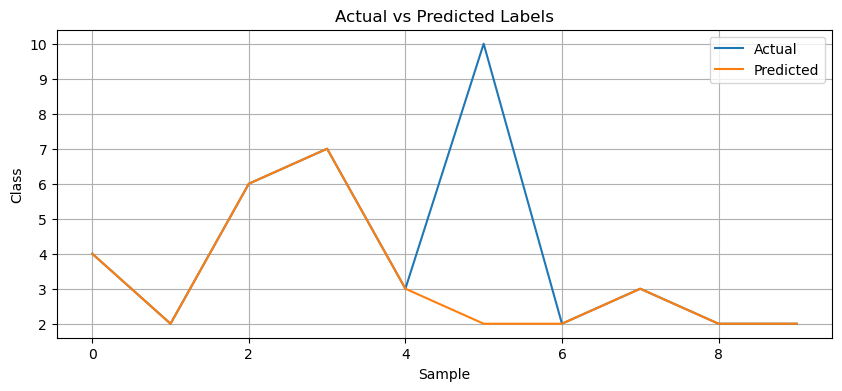

In [63]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.LeakyReLU()
learning_rate = 0.01
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 3, Epochs = 100 for Layer = 1, hidden_layer = 64

Epoch [1/100], Average Loss: 2.3250
Epoch [2/100], Average Loss: 1.8743
Epoch [3/100], Average Loss: 1.5059
Epoch [4/100], Average Loss: 1.3047
Epoch [5/100], Average Loss: 1.1861
Epoch [6/100], Average Loss: 1.0971
Epoch [7/100], Average Loss: 1.0366
Epoch [8/100], Average Loss: 0.9872
Epoch [9/100], Average Loss: 0.9386
Epoch [10/100], Average Loss: 0.9066
Epoch [11/100], Average Loss: 0.8742
Epoch [12/100], Average Loss: 0.8506
Epoch [13/100], Average Loss: 0.8198
Epoch [14/100], Average Loss: 0.8025
Epoch [15/100], Average Loss: 0.7825
Epoch [16/100], Average Loss: 0.7658
Epoch [17/100], Average Loss: 0.7480
Epoch [18/100], Average Loss: 0.7246
Epoch [19/100], Average Loss: 0.7095
Epoch [20/100], Average Loss: 0.6911
Epoch [21/100], Average Loss: 0.6780
Epoch [22/100], Average Loss: 0.6625
Epoch [23/100], Average Loss: 0.6594
Epoch [24/100], Average Loss: 0.6369
Epoch [25/100], Average Loss: 0.6249
Epoch [26/100], Average Loss: 0.6073
Epoch [27/100], Average Loss: 0.5954
Epoch [28/

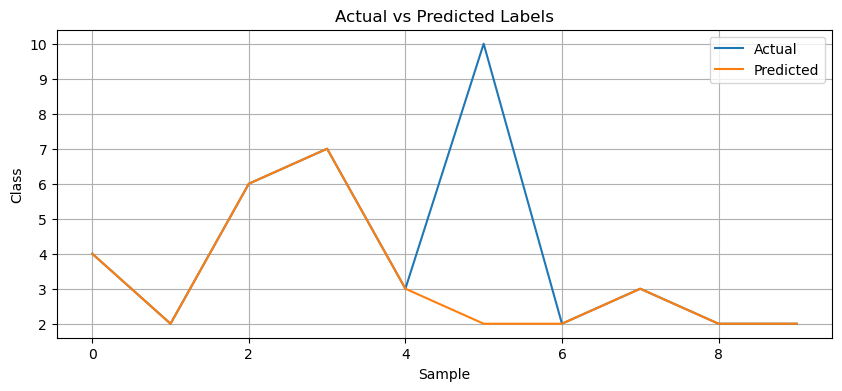

In [21]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.LeakyReLU()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 1.5408
Epoch [2/100], Average Loss: 0.9641
Epoch [3/100], Average Loss: 0.8399
Epoch [4/100], Average Loss: 0.7636
Epoch [5/100], Average Loss: 0.6859
Epoch [6/100], Average Loss: 0.6127
Epoch [7/100], Average Loss: 0.5506
Epoch [8/100], Average Loss: 0.5631
Epoch [9/100], Average Loss: 0.5111
Epoch [10/100], Average Loss: 0.4962
Epoch [11/100], Average Loss: 0.4785
Epoch [12/100], Average Loss: 0.4450
Epoch [13/100], Average Loss: 0.4172
Epoch [14/100], Average Loss: 0.4265
Epoch [15/100], Average Loss: 0.4077
Epoch [16/100], Average Loss: 0.4204
Epoch [17/100], Average Loss: 0.4040
Epoch [18/100], Average Loss: 0.4329
Epoch [19/100], Average Loss: 0.4170
Epoch [20/100], Average Loss: 0.3696
Epoch [21/100], Average Loss: 0.3737
Epoch [22/100], Average Loss: 0.3954
Epoch [23/100], Average Loss: 0.3693
Epoch [24/100], Average Loss: 0.3632
Epoch [25/100], Average Loss: 0.3897
Epoch [26/100], Average Loss: 0.3433
Epoch [27/100], Average Loss: 0.3361
Epoch [28/

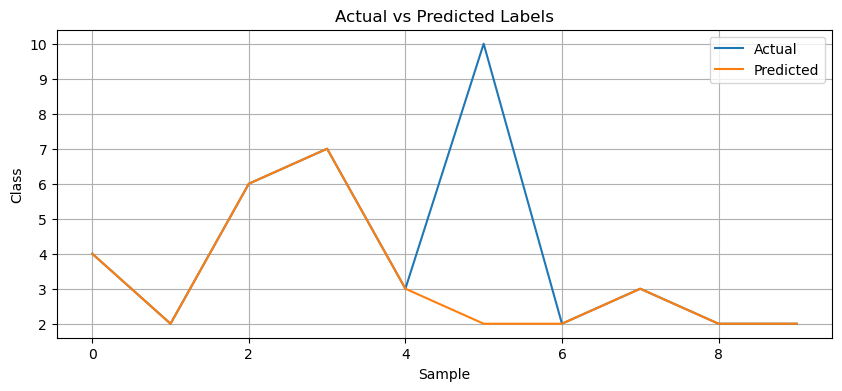

In [64]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.LeakyReLU()
learning_rate = 0.01
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 4, Epochs = 100 for Layer = 2, hidden_layer = 64

Epoch [1/100], Average Loss: 2.3465
Epoch [2/100], Average Loss: 1.5801
Epoch [3/100], Average Loss: 1.1440
Epoch [4/100], Average Loss: 1.0019
Epoch [5/100], Average Loss: 0.9288
Epoch [6/100], Average Loss: 0.8758
Epoch [7/100], Average Loss: 0.8400
Epoch [8/100], Average Loss: 0.8159
Epoch [9/100], Average Loss: 0.7824
Epoch [10/100], Average Loss: 0.7714
Epoch [11/100], Average Loss: 0.7482
Epoch [12/100], Average Loss: 0.7238
Epoch [13/100], Average Loss: 0.7156
Epoch [14/100], Average Loss: 0.7017
Epoch [15/100], Average Loss: 0.6871
Epoch [16/100], Average Loss: 0.6734
Epoch [17/100], Average Loss: 0.6579
Epoch [18/100], Average Loss: 0.6443
Epoch [19/100], Average Loss: 0.6330
Epoch [20/100], Average Loss: 0.6233
Epoch [21/100], Average Loss: 0.6009
Epoch [22/100], Average Loss: 0.5869
Epoch [23/100], Average Loss: 0.5731
Epoch [24/100], Average Loss: 0.5645
Epoch [25/100], Average Loss: 0.5522
Epoch [26/100], Average Loss: 0.5191
Epoch [27/100], Average Loss: 0.5048
Epoch [28/

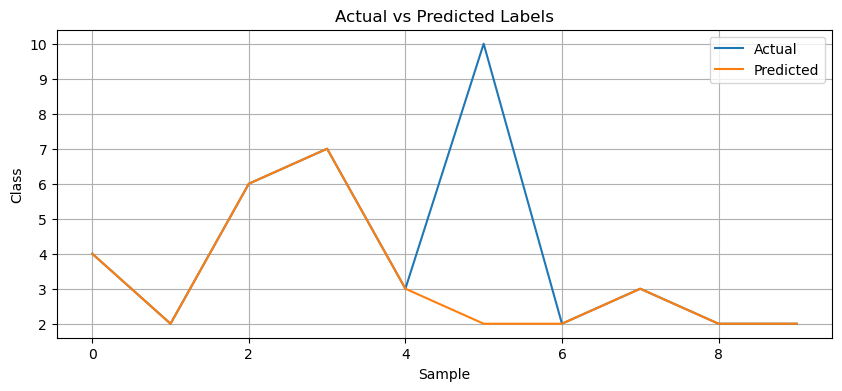

In [22]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.LeakyReLU()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 1.4646
Epoch [2/100], Average Loss: 0.9138
Epoch [3/100], Average Loss: 0.8122
Epoch [4/100], Average Loss: 0.7380
Epoch [5/100], Average Loss: 0.7079
Epoch [6/100], Average Loss: 0.7387
Epoch [7/100], Average Loss: 0.6442
Epoch [8/100], Average Loss: 0.5934
Epoch [9/100], Average Loss: 0.5410
Epoch [10/100], Average Loss: 0.5083
Epoch [11/100], Average Loss: 0.4837
Epoch [12/100], Average Loss: 0.4971
Epoch [13/100], Average Loss: 0.4319
Epoch [14/100], Average Loss: 0.3864
Epoch [15/100], Average Loss: 0.4255
Epoch [16/100], Average Loss: 0.4211
Epoch [17/100], Average Loss: 0.4444
Epoch [18/100], Average Loss: 0.4140
Epoch [19/100], Average Loss: 0.3592
Epoch [20/100], Average Loss: 0.4072
Epoch [21/100], Average Loss: 0.3524
Epoch [22/100], Average Loss: 0.4367
Epoch [23/100], Average Loss: 0.3762
Epoch [24/100], Average Loss: 0.3148
Epoch [25/100], Average Loss: 0.3853
Epoch [26/100], Average Loss: 0.3160
Epoch [27/100], Average Loss: 0.3132
Epoch [28/

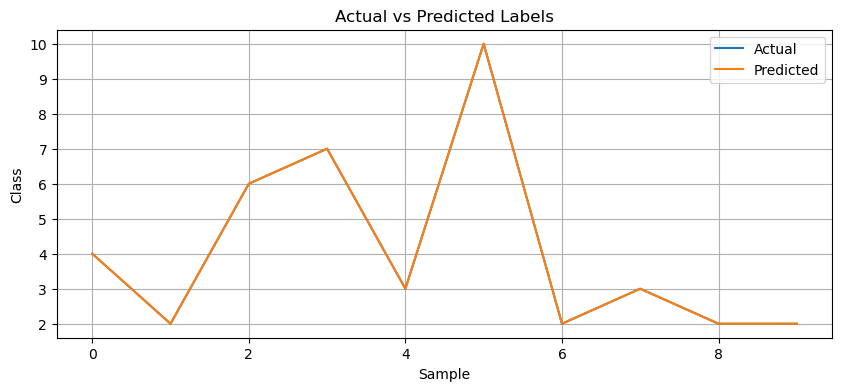

In [66]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.LeakyReLU()
learning_rate = 0.01
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 5, Epochs = 100 for Layer = 3, hidden_layer = 128

Epoch [1/100], Average Loss: 2.0844
Epoch [2/100], Average Loss: 1.1445
Epoch [3/100], Average Loss: 0.9749
Epoch [4/100], Average Loss: 0.8871
Epoch [5/100], Average Loss: 0.8128
Epoch [6/100], Average Loss: 0.7691
Epoch [7/100], Average Loss: 0.7437
Epoch [8/100], Average Loss: 0.7319
Epoch [9/100], Average Loss: 0.7373
Epoch [10/100], Average Loss: 0.6894
Epoch [11/100], Average Loss: 0.6705
Epoch [12/100], Average Loss: 0.6676
Epoch [13/100], Average Loss: 0.6672
Epoch [14/100], Average Loss: 0.6571
Epoch [15/100], Average Loss: 0.6359
Epoch [16/100], Average Loss: 0.6300
Epoch [17/100], Average Loss: 0.6270
Epoch [18/100], Average Loss: 0.6139
Epoch [19/100], Average Loss: 0.6064
Epoch [20/100], Average Loss: 0.6077
Epoch [21/100], Average Loss: 0.5809
Epoch [22/100], Average Loss: 0.5911
Epoch [23/100], Average Loss: 0.5860
Epoch [24/100], Average Loss: 0.5806
Epoch [25/100], Average Loss: 0.5681
Epoch [26/100], Average Loss: 0.5553
Epoch [27/100], Average Loss: 0.5159
Epoch [28/

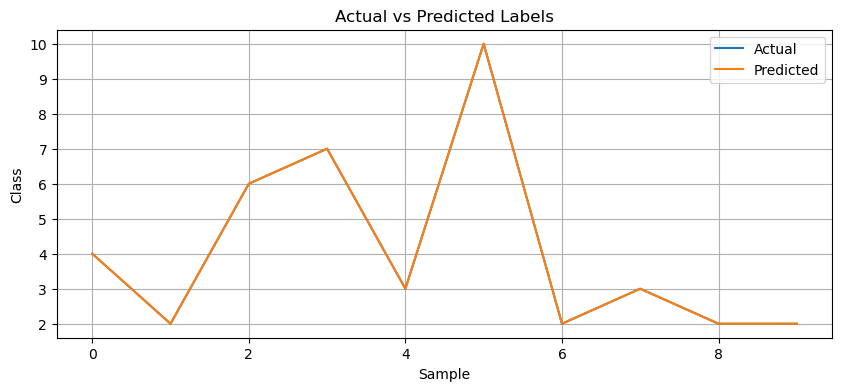

In [23]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 128
num_layers = 3
activation = nn.LeakyReLU()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 1.3086
Epoch [2/100], Average Loss: 0.9906
Epoch [3/100], Average Loss: 0.9020
Epoch [4/100], Average Loss: 0.8364
Epoch [5/100], Average Loss: 0.7570
Epoch [6/100], Average Loss: 0.6810
Epoch [7/100], Average Loss: 0.6660
Epoch [8/100], Average Loss: 0.6354
Epoch [9/100], Average Loss: 0.6405
Epoch [10/100], Average Loss: 0.7135
Epoch [11/100], Average Loss: 0.6601
Epoch [12/100], Average Loss: 0.5373
Epoch [13/100], Average Loss: 0.5570
Epoch [14/100], Average Loss: 0.5232
Epoch [15/100], Average Loss: 0.5129
Epoch [16/100], Average Loss: 0.4769
Epoch [17/100], Average Loss: 0.4867
Epoch [18/100], Average Loss: 0.4643
Epoch [19/100], Average Loss: 0.4444
Epoch [20/100], Average Loss: 0.4775
Epoch [21/100], Average Loss: 0.4343
Epoch [22/100], Average Loss: 0.4073
Epoch [23/100], Average Loss: 0.3896
Epoch [24/100], Average Loss: 0.3888
Epoch [25/100], Average Loss: 0.3552
Epoch [26/100], Average Loss: 0.3685
Epoch [27/100], Average Loss: 0.3849
Epoch [28/

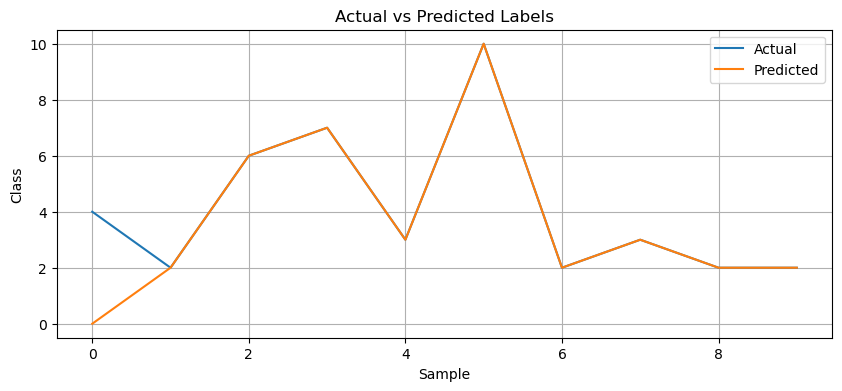

In [67]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 128
num_layers = 3
activation = nn.LeakyReLU()
learning_rate = 0.01
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 6, Epochs = 1000 for Layer = 4, hidden_layer = 256

Epoch [1/1000], Average Loss: 1.8227
Epoch [2/1000], Average Loss: 1.0216
Epoch [3/1000], Average Loss: 0.8978
Epoch [4/1000], Average Loss: 0.8383
Epoch [5/1000], Average Loss: 0.8411
Epoch [6/1000], Average Loss: 0.7397
Epoch [7/1000], Average Loss: 0.7228
Epoch [8/1000], Average Loss: 0.7208
Epoch [9/1000], Average Loss: 0.7085
Epoch [10/1000], Average Loss: 0.6961
Epoch [11/1000], Average Loss: 0.7015
Epoch [12/1000], Average Loss: 0.6629
Epoch [13/1000], Average Loss: 0.6933
Epoch [14/1000], Average Loss: 0.6331
Epoch [15/1000], Average Loss: 0.6377
Epoch [16/1000], Average Loss: 0.6658
Epoch [17/1000], Average Loss: 0.6244
Epoch [18/1000], Average Loss: 0.6210
Epoch [19/1000], Average Loss: 0.6061
Epoch [20/1000], Average Loss: 0.5851
Epoch [21/1000], Average Loss: 0.6120
Epoch [22/1000], Average Loss: 0.6057
Epoch [23/1000], Average Loss: 0.6001
Epoch [24/1000], Average Loss: 0.5473
Epoch [25/1000], Average Loss: 0.5345
Epoch [26/1000], Average Loss: 0.5337
Epoch [27/1000], Aver

Epoch [214/1000], Average Loss: 0.1628
Epoch [215/1000], Average Loss: 0.2100
Epoch [216/1000], Average Loss: 0.1904
Epoch [217/1000], Average Loss: 0.1783
Epoch [218/1000], Average Loss: 0.1489
Epoch [219/1000], Average Loss: 0.1841
Epoch [220/1000], Average Loss: 0.1579
Epoch [221/1000], Average Loss: 0.1619
Epoch [222/1000], Average Loss: 0.1607
Epoch [223/1000], Average Loss: 0.1502
Epoch [224/1000], Average Loss: 0.2123
Epoch [225/1000], Average Loss: 0.1843
Epoch [226/1000], Average Loss: 0.1523
Epoch [227/1000], Average Loss: 0.1595
Epoch [228/1000], Average Loss: 0.2043
Epoch [229/1000], Average Loss: 0.1942
Epoch [230/1000], Average Loss: 0.1628
Epoch [231/1000], Average Loss: 0.1849
Epoch [232/1000], Average Loss: 0.2266
Epoch [233/1000], Average Loss: 0.1738
Epoch [234/1000], Average Loss: 0.1457
Epoch [235/1000], Average Loss: 0.1707
Epoch [236/1000], Average Loss: 0.1386
Epoch [237/1000], Average Loss: 0.1529
Epoch [238/1000], Average Loss: 0.1527
Epoch [239/1000], Average

Epoch [425/1000], Average Loss: 0.1117
Epoch [426/1000], Average Loss: 0.1039
Epoch [427/1000], Average Loss: 0.1097
Epoch [428/1000], Average Loss: 0.1517
Epoch [429/1000], Average Loss: 0.1355
Epoch [430/1000], Average Loss: 0.1077
Epoch [431/1000], Average Loss: 0.1057
Epoch [432/1000], Average Loss: 0.1088
Epoch [433/1000], Average Loss: 0.0997
Epoch [434/1000], Average Loss: 0.1337
Epoch [435/1000], Average Loss: 0.1849
Epoch [436/1000], Average Loss: 0.1770
Epoch [437/1000], Average Loss: 0.1373
Epoch [438/1000], Average Loss: 0.1186
Epoch [439/1000], Average Loss: 0.1075
Epoch [440/1000], Average Loss: 0.1042
Epoch [441/1000], Average Loss: 0.1579
Epoch [442/1000], Average Loss: 0.1364
Epoch [443/1000], Average Loss: 0.1050
Epoch [444/1000], Average Loss: 0.1202
Epoch [445/1000], Average Loss: 0.1647
Epoch [446/1000], Average Loss: 0.1012
Epoch [447/1000], Average Loss: 0.0937
Epoch [448/1000], Average Loss: 0.0903
Epoch [449/1000], Average Loss: 0.0963
Epoch [450/1000], Average

Epoch [636/1000], Average Loss: 0.0841
Epoch [637/1000], Average Loss: 0.0945
Epoch [638/1000], Average Loss: 0.1247
Epoch [639/1000], Average Loss: 0.1059
Epoch [640/1000], Average Loss: 0.1044
Epoch [641/1000], Average Loss: 0.0919
Epoch [642/1000], Average Loss: 0.0891
Epoch [643/1000], Average Loss: 0.0674
Epoch [644/1000], Average Loss: 0.0929
Epoch [645/1000], Average Loss: 0.0951
Epoch [646/1000], Average Loss: 0.1007
Epoch [647/1000], Average Loss: 0.1194
Epoch [648/1000], Average Loss: 0.0602
Epoch [649/1000], Average Loss: 0.0774
Epoch [650/1000], Average Loss: 0.0615
Epoch [651/1000], Average Loss: 0.0876
Epoch [652/1000], Average Loss: 0.1104
Epoch [653/1000], Average Loss: 0.0768
Epoch [654/1000], Average Loss: 0.0973
Epoch [655/1000], Average Loss: 0.0805
Epoch [656/1000], Average Loss: 0.0815
Epoch [657/1000], Average Loss: 0.0894
Epoch [658/1000], Average Loss: 0.1072
Epoch [659/1000], Average Loss: 0.0788
Epoch [660/1000], Average Loss: 0.0792
Epoch [661/1000], Average

Epoch [847/1000], Average Loss: 0.0557
Epoch [848/1000], Average Loss: 0.0511
Epoch [849/1000], Average Loss: 0.0558
Epoch [850/1000], Average Loss: 0.1039
Epoch [851/1000], Average Loss: 0.0699
Epoch [852/1000], Average Loss: 0.0568
Epoch [853/1000], Average Loss: 0.0541
Epoch [854/1000], Average Loss: 0.1536
Epoch [855/1000], Average Loss: 0.1040
Epoch [856/1000], Average Loss: 0.0981
Epoch [857/1000], Average Loss: 0.0690
Epoch [858/1000], Average Loss: 0.1239
Epoch [859/1000], Average Loss: 0.0784
Epoch [860/1000], Average Loss: 0.0805
Epoch [861/1000], Average Loss: 0.0704
Epoch [862/1000], Average Loss: 0.0477
Epoch [863/1000], Average Loss: 0.0462
Epoch [864/1000], Average Loss: 0.0368
Epoch [865/1000], Average Loss: 0.0589
Epoch [866/1000], Average Loss: 0.0417
Epoch [867/1000], Average Loss: 0.0738
Epoch [868/1000], Average Loss: 0.0643
Epoch [869/1000], Average Loss: 0.0717
Epoch [870/1000], Average Loss: 0.0420
Epoch [871/1000], Average Loss: 0.0573
Epoch [872/1000], Average

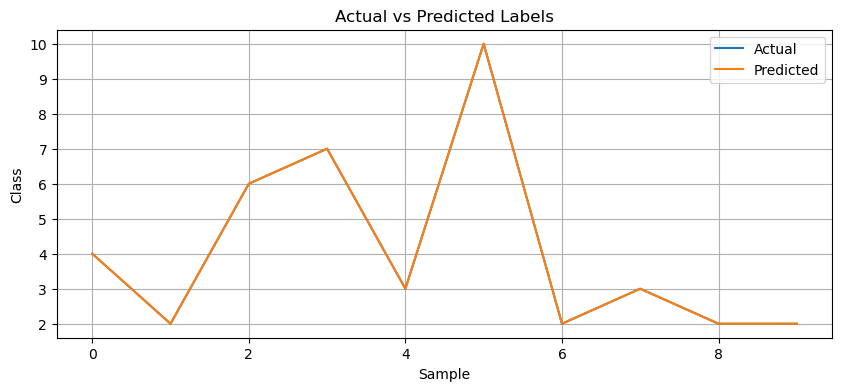

In [24]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 256
num_layers = 4
activation = nn.ReLU()
learning_rate = 0.001
epochs = 1000

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/1000], Average Loss: 1.6938
Epoch [2/1000], Average Loss: 1.1269
Epoch [3/1000], Average Loss: 0.9784
Epoch [4/1000], Average Loss: 0.8834
Epoch [5/1000], Average Loss: 0.9650
Epoch [6/1000], Average Loss: 0.8744
Epoch [7/1000], Average Loss: 0.8222
Epoch [8/1000], Average Loss: 0.8160
Epoch [9/1000], Average Loss: 0.7362
Epoch [10/1000], Average Loss: 0.6971
Epoch [11/1000], Average Loss: 0.6945
Epoch [12/1000], Average Loss: 0.6711
Epoch [13/1000], Average Loss: 0.6358
Epoch [14/1000], Average Loss: 0.6513
Epoch [15/1000], Average Loss: 0.5741
Epoch [16/1000], Average Loss: 0.6007
Epoch [17/1000], Average Loss: 0.5597
Epoch [18/1000], Average Loss: 0.6042
Epoch [19/1000], Average Loss: 0.7369
Epoch [20/1000], Average Loss: 0.6006
Epoch [21/1000], Average Loss: 0.7813
Epoch [22/1000], Average Loss: 0.5231
Epoch [23/1000], Average Loss: 0.5071
Epoch [24/1000], Average Loss: 0.5017
Epoch [25/1000], Average Loss: 0.4973
Epoch [26/1000], Average Loss: 0.4363
Epoch [27/1000], Aver

Epoch [214/1000], Average Loss: 0.3258
Epoch [215/1000], Average Loss: 0.2785
Epoch [216/1000], Average Loss: 0.2964
Epoch [217/1000], Average Loss: 0.2655
Epoch [218/1000], Average Loss: 0.2243
Epoch [219/1000], Average Loss: 0.2267
Epoch [220/1000], Average Loss: 0.3048
Epoch [221/1000], Average Loss: 0.2069
Epoch [222/1000], Average Loss: 0.2059
Epoch [223/1000], Average Loss: 0.2406
Epoch [224/1000], Average Loss: 0.1994
Epoch [225/1000], Average Loss: 0.2406
Epoch [226/1000], Average Loss: 0.2334
Epoch [227/1000], Average Loss: 0.2484
Epoch [228/1000], Average Loss: 0.2143
Epoch [229/1000], Average Loss: 0.1963
Epoch [230/1000], Average Loss: 0.3044
Epoch [231/1000], Average Loss: 0.2079
Epoch [232/1000], Average Loss: 0.1938
Epoch [233/1000], Average Loss: 0.2558
Epoch [234/1000], Average Loss: 0.1876
Epoch [235/1000], Average Loss: 0.1971
Epoch [236/1000], Average Loss: 0.2401
Epoch [237/1000], Average Loss: 0.2170
Epoch [238/1000], Average Loss: 0.1834
Epoch [239/1000], Average

Epoch [425/1000], Average Loss: 0.1782
Epoch [426/1000], Average Loss: 0.1898
Epoch [427/1000], Average Loss: 0.1900
Epoch [428/1000], Average Loss: 0.1662
Epoch [429/1000], Average Loss: 0.1500
Epoch [430/1000], Average Loss: 0.2096
Epoch [431/1000], Average Loss: 0.3199
Epoch [432/1000], Average Loss: 0.1705
Epoch [433/1000], Average Loss: 0.1627
Epoch [434/1000], Average Loss: 0.1671
Epoch [435/1000], Average Loss: 0.1929
Epoch [436/1000], Average Loss: 0.1605
Epoch [437/1000], Average Loss: 0.2675
Epoch [438/1000], Average Loss: 0.2678
Epoch [439/1000], Average Loss: 0.1929
Epoch [440/1000], Average Loss: 0.2508
Epoch [441/1000], Average Loss: 0.2431
Epoch [442/1000], Average Loss: 0.2579
Epoch [443/1000], Average Loss: 0.2621
Epoch [444/1000], Average Loss: 0.1844
Epoch [445/1000], Average Loss: 0.1762
Epoch [446/1000], Average Loss: 0.1821
Epoch [447/1000], Average Loss: 0.2370
Epoch [448/1000], Average Loss: 0.1912
Epoch [449/1000], Average Loss: 0.1702
Epoch [450/1000], Average

Epoch [636/1000], Average Loss: 0.2979
Epoch [637/1000], Average Loss: 0.2340
Epoch [638/1000], Average Loss: 0.2427
Epoch [639/1000], Average Loss: 0.2391
Epoch [640/1000], Average Loss: 0.2546
Epoch [641/1000], Average Loss: 0.1802
Epoch [642/1000], Average Loss: 0.1673
Epoch [643/1000], Average Loss: 0.1442
Epoch [644/1000], Average Loss: 0.1795
Epoch [645/1000], Average Loss: 0.1628
Epoch [646/1000], Average Loss: 0.2255
Epoch [647/1000], Average Loss: 0.1607
Epoch [648/1000], Average Loss: 0.2156
Epoch [649/1000], Average Loss: 0.2297
Epoch [650/1000], Average Loss: 0.1987
Epoch [651/1000], Average Loss: 0.1838
Epoch [652/1000], Average Loss: 0.1717
Epoch [653/1000], Average Loss: 0.1608
Epoch [654/1000], Average Loss: 0.1456
Epoch [655/1000], Average Loss: 0.1636
Epoch [656/1000], Average Loss: 0.1615
Epoch [657/1000], Average Loss: 0.1739
Epoch [658/1000], Average Loss: 0.2153
Epoch [659/1000], Average Loss: 0.1815
Epoch [660/1000], Average Loss: 0.1720
Epoch [661/1000], Average

Epoch [847/1000], Average Loss: 0.1871
Epoch [848/1000], Average Loss: 0.2454
Epoch [849/1000], Average Loss: 0.2224
Epoch [850/1000], Average Loss: 0.1724
Epoch [851/1000], Average Loss: 0.1726
Epoch [852/1000], Average Loss: 0.1475
Epoch [853/1000], Average Loss: 0.1770
Epoch [854/1000], Average Loss: 0.1677
Epoch [855/1000], Average Loss: 0.1560
Epoch [856/1000], Average Loss: 0.1884
Epoch [857/1000], Average Loss: 0.2088
Epoch [858/1000], Average Loss: 0.2146
Epoch [859/1000], Average Loss: 0.1732
Epoch [860/1000], Average Loss: 0.1801
Epoch [861/1000], Average Loss: 0.2405
Epoch [862/1000], Average Loss: 0.1660
Epoch [863/1000], Average Loss: 0.3160
Epoch [864/1000], Average Loss: 0.2958
Epoch [865/1000], Average Loss: 0.1751
Epoch [866/1000], Average Loss: 0.1874
Epoch [867/1000], Average Loss: 0.1584
Epoch [868/1000], Average Loss: 0.1445
Epoch [869/1000], Average Loss: 0.2580
Epoch [870/1000], Average Loss: 0.2301
Epoch [871/1000], Average Loss: 0.1651
Epoch [872/1000], Average

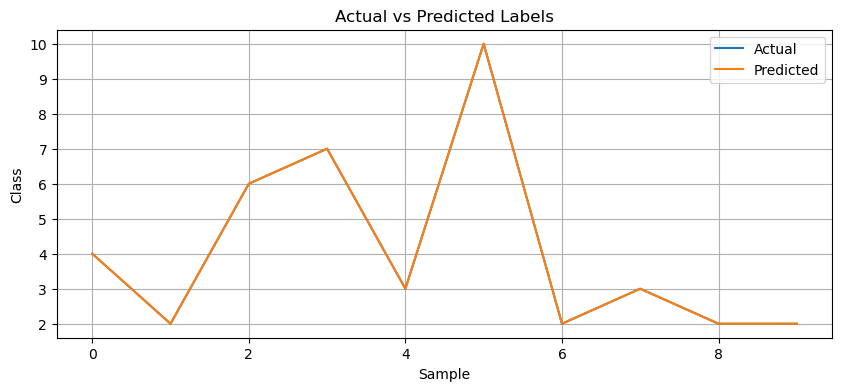

In [74]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 256
num_layers = 4
activation = nn.ReLU()
learning_rate = 0.01
epochs = 1000

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

## Sigmoid Activation Function

### Setting 1, Epochs = 10 for Layer = 1, hidden_layer = 64

Epoch [1/10], Average Loss: 2.4076
Epoch [2/10], Average Loss: 2.1435
Epoch [3/10], Average Loss: 1.9388
Epoch [4/10], Average Loss: 1.7647
Epoch [5/10], Average Loss: 1.6310
Epoch [6/10], Average Loss: 1.5322
Epoch [7/10], Average Loss: 1.4559
Epoch [8/10], Average Loss: 1.3931
Epoch [9/10], Average Loss: 1.3408
Epoch [10/10], Average Loss: 1.2957
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 58.82%
Predicted Labels:
[4 2 4 ... 4 2 4]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 58.82352941176471 %


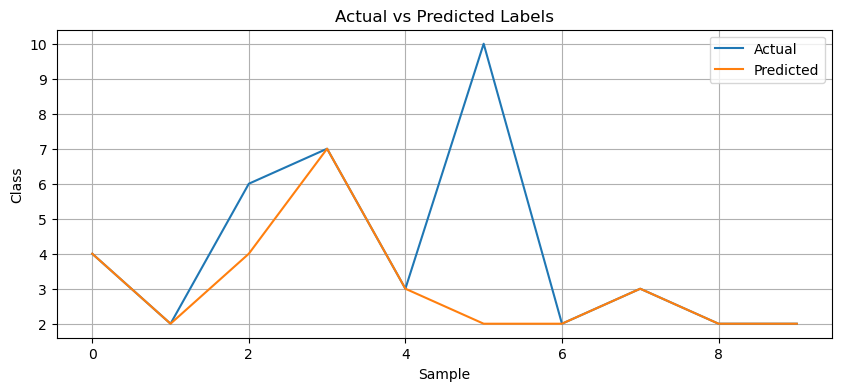

In [25]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.Sigmoid()
learning_rate = 0.001
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/10], Average Loss: 1.7879
Epoch [2/10], Average Loss: 1.1933
Epoch [3/10], Average Loss: 1.0307
Epoch [4/10], Average Loss: 0.9143
Epoch [5/10], Average Loss: 0.8205
Epoch [6/10], Average Loss: 0.7462
Epoch [7/10], Average Loss: 0.6933
Epoch [8/10], Average Loss: 0.6479
Epoch [9/10], Average Loss: 0.5966
Epoch [10/10], Average Loss: 0.5665
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 80.37%
Predicted Labels:
[ 4  2  6 ...  8 10  6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 80.37084398976982 %


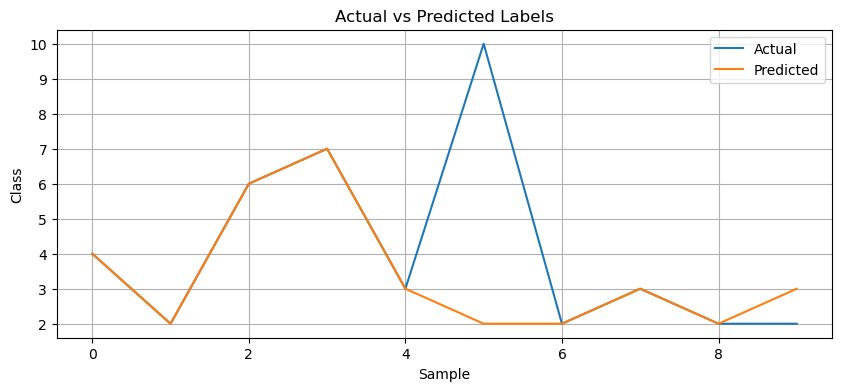

In [68]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.Sigmoid()
learning_rate = 0.01
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 2, Epochs = 10 for Layer = 2, hidden_layer = 64

Epoch [1/10], Average Loss: 2.4299
Epoch [2/10], Average Loss: 2.2815
Epoch [3/10], Average Loss: 2.0443
Epoch [4/10], Average Loss: 1.8352
Epoch [5/10], Average Loss: 1.6663
Epoch [6/10], Average Loss: 1.5263
Epoch [7/10], Average Loss: 1.4246
Epoch [8/10], Average Loss: 1.3461
Epoch [9/10], Average Loss: 1.2835
Epoch [10/10], Average Loss: 1.2258
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 62.92%
Predicted Labels:
[4 2 4 ... 4 2 4]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 62.9156010230179 %


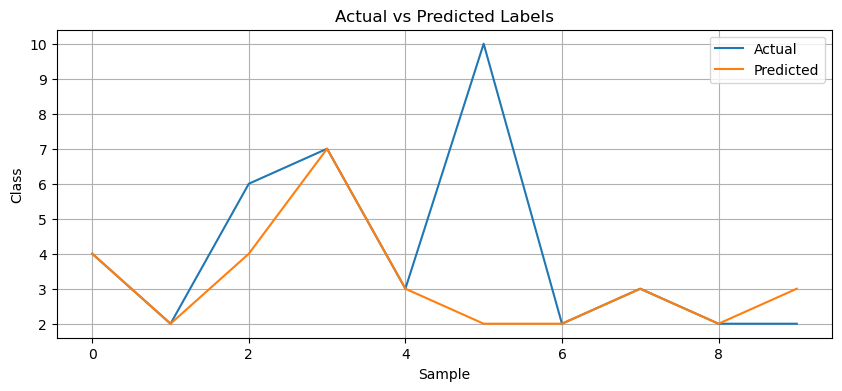

In [26]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.Sigmoid()
learning_rate = 0.001
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/10], Average Loss: 1.8807
Epoch [2/10], Average Loss: 1.1429
Epoch [3/10], Average Loss: 0.9763
Epoch [4/10], Average Loss: 0.8926
Epoch [5/10], Average Loss: 0.8291
Epoch [6/10], Average Loss: 0.7778
Epoch [7/10], Average Loss: 0.7414
Epoch [8/10], Average Loss: 0.7612
Epoch [9/10], Average Loss: 0.7102
Epoch [10/10], Average Loss: 0.6609
Training finished.
MyModel(
  (model): Sequential(
    (0): Linear(in_features=176, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 79.16%
Predicted Labels:
[ 4  2  6 ...  8 10  6]
Actual Labels:
[4 2 6 ... 8 2 6]
Accuracy: 79.15601023017904 %


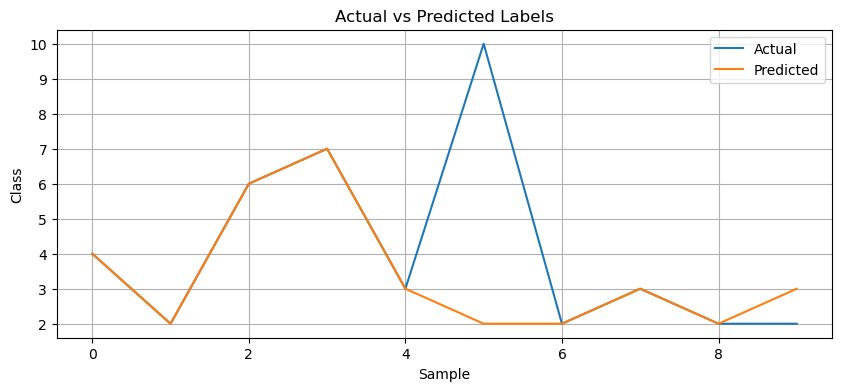

In [69]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.Sigmoid()
learning_rate = 0.01
epochs = 10

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 3, Epochs = 100 for Layer = 1, hidden_layer = 64

Epoch [1/100], Average Loss: 2.3584
Epoch [2/100], Average Loss: 2.1095
Epoch [3/100], Average Loss: 1.8949
Epoch [4/100], Average Loss: 1.7200
Epoch [5/100], Average Loss: 1.5907
Epoch [6/100], Average Loss: 1.4962
Epoch [7/100], Average Loss: 1.4235
Epoch [8/100], Average Loss: 1.3633
Epoch [9/100], Average Loss: 1.3141
Epoch [10/100], Average Loss: 1.2711
Epoch [11/100], Average Loss: 1.2322
Epoch [12/100], Average Loss: 1.1989
Epoch [13/100], Average Loss: 1.1673
Epoch [14/100], Average Loss: 1.1401
Epoch [15/100], Average Loss: 1.1117
Epoch [16/100], Average Loss: 1.0865
Epoch [17/100], Average Loss: 1.0630
Epoch [18/100], Average Loss: 1.0410
Epoch [19/100], Average Loss: 1.0177
Epoch [20/100], Average Loss: 1.0011
Epoch [21/100], Average Loss: 0.9786
Epoch [22/100], Average Loss: 0.9603
Epoch [23/100], Average Loss: 0.9422
Epoch [24/100], Average Loss: 0.9251
Epoch [25/100], Average Loss: 0.9105
Epoch [26/100], Average Loss: 0.8931
Epoch [27/100], Average Loss: 0.8772
Epoch [28/

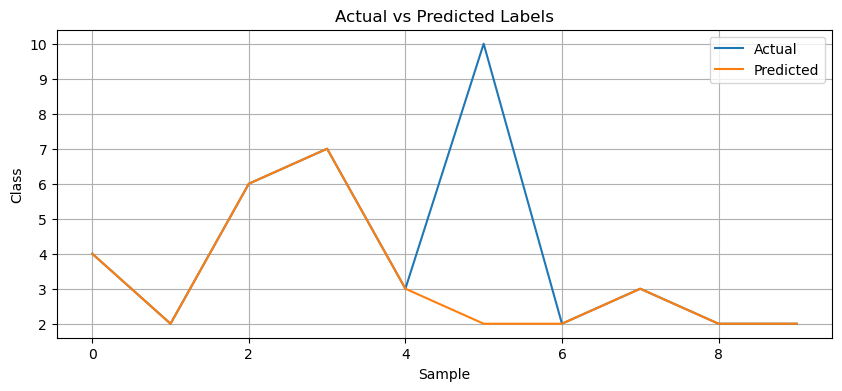

In [27]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.Sigmoid()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 1.7900
Epoch [2/100], Average Loss: 1.1934
Epoch [3/100], Average Loss: 1.0154
Epoch [4/100], Average Loss: 0.9048
Epoch [5/100], Average Loss: 0.7900
Epoch [6/100], Average Loss: 0.7098
Epoch [7/100], Average Loss: 0.6557
Epoch [8/100], Average Loss: 0.5908
Epoch [9/100], Average Loss: 0.5744
Epoch [10/100], Average Loss: 0.5240
Epoch [11/100], Average Loss: 0.4855
Epoch [12/100], Average Loss: 0.4695
Epoch [13/100], Average Loss: 0.4542
Epoch [14/100], Average Loss: 0.4592
Epoch [15/100], Average Loss: 0.4227
Epoch [16/100], Average Loss: 0.4261
Epoch [17/100], Average Loss: 0.4106
Epoch [18/100], Average Loss: 0.3936
Epoch [19/100], Average Loss: 0.4111
Epoch [20/100], Average Loss: 0.3741
Epoch [21/100], Average Loss: 0.3759
Epoch [22/100], Average Loss: 0.3696
Epoch [23/100], Average Loss: 0.3565
Epoch [24/100], Average Loss: 0.3546
Epoch [25/100], Average Loss: 0.3700
Epoch [26/100], Average Loss: 0.3501
Epoch [27/100], Average Loss: 0.3459
Epoch [28/

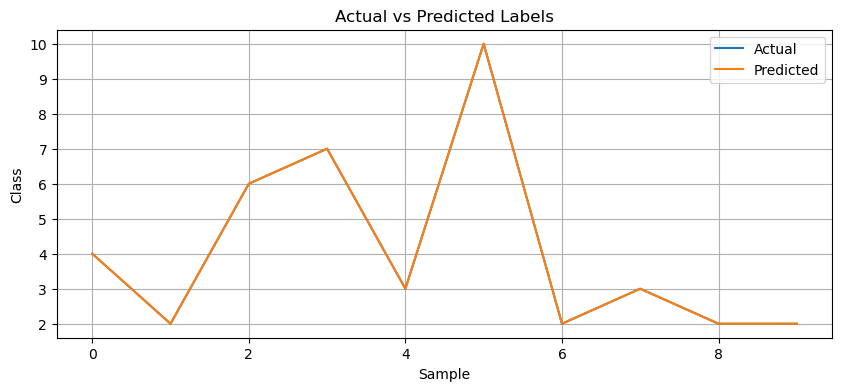

In [70]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 1
activation = nn.Sigmoid()
learning_rate = 0.01
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 4, Epochs = 100 for Layer = 2, hidden_layer = 64

Epoch [1/100], Average Loss: 2.4161
Epoch [2/100], Average Loss: 2.2863
Epoch [3/100], Average Loss: 2.0318
Epoch [4/100], Average Loss: 1.7931
Epoch [5/100], Average Loss: 1.6265
Epoch [6/100], Average Loss: 1.5002
Epoch [7/100], Average Loss: 1.4009
Epoch [8/100], Average Loss: 1.3199
Epoch [9/100], Average Loss: 1.2505
Epoch [10/100], Average Loss: 1.1934
Epoch [11/100], Average Loss: 1.1463
Epoch [12/100], Average Loss: 1.1050
Epoch [13/100], Average Loss: 1.0690
Epoch [14/100], Average Loss: 1.0412
Epoch [15/100], Average Loss: 1.0140
Epoch [16/100], Average Loss: 0.9924
Epoch [17/100], Average Loss: 0.9671
Epoch [18/100], Average Loss: 0.9464
Epoch [19/100], Average Loss: 0.9259
Epoch [20/100], Average Loss: 0.9008
Epoch [21/100], Average Loss: 0.8827
Epoch [22/100], Average Loss: 0.8647
Epoch [23/100], Average Loss: 0.8480
Epoch [24/100], Average Loss: 0.8326
Epoch [25/100], Average Loss: 0.8197
Epoch [26/100], Average Loss: 0.8072
Epoch [27/100], Average Loss: 0.7951
Epoch [28/

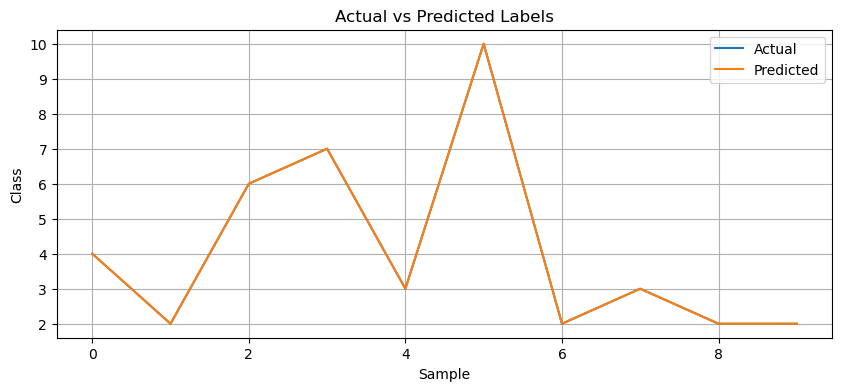

In [28]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.Sigmoid()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 1.8924
Epoch [2/100], Average Loss: 1.1803
Epoch [3/100], Average Loss: 1.0029
Epoch [4/100], Average Loss: 0.9172
Epoch [5/100], Average Loss: 0.8772
Epoch [6/100], Average Loss: 0.7855
Epoch [7/100], Average Loss: 0.7539
Epoch [8/100], Average Loss: 0.7095
Epoch [9/100], Average Loss: 0.6977
Epoch [10/100], Average Loss: 0.6473
Epoch [11/100], Average Loss: 0.6331
Epoch [12/100], Average Loss: 0.6227
Epoch [13/100], Average Loss: 0.5906
Epoch [14/100], Average Loss: 0.5662
Epoch [15/100], Average Loss: 0.5580
Epoch [16/100], Average Loss: 0.5550
Epoch [17/100], Average Loss: 0.5057
Epoch [18/100], Average Loss: 0.4956
Epoch [19/100], Average Loss: 0.5006
Epoch [20/100], Average Loss: 0.4601
Epoch [21/100], Average Loss: 0.4454
Epoch [22/100], Average Loss: 0.4659
Epoch [23/100], Average Loss: 0.4103
Epoch [24/100], Average Loss: 0.4354
Epoch [25/100], Average Loss: 0.3971
Epoch [26/100], Average Loss: 0.3904
Epoch [27/100], Average Loss: 0.3583
Epoch [28/

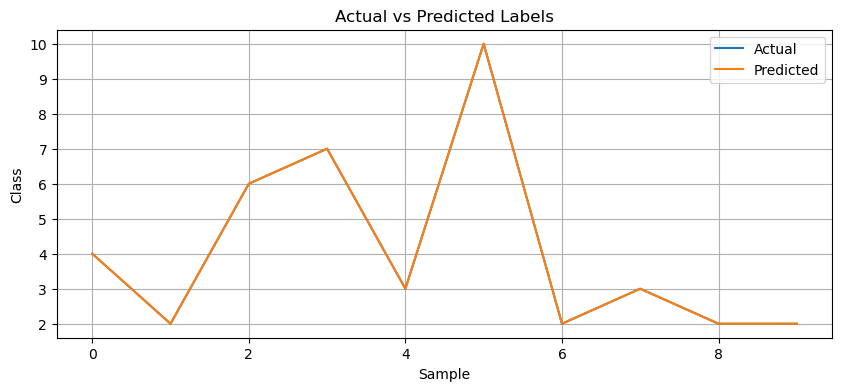

In [71]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 64
num_layers = 2
activation = nn.Sigmoid()
learning_rate = 0.01
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 5, Epochs = 100 for Layer = 3, hidden_layer = 128

Epoch [1/100], Average Loss: 2.4298
Epoch [2/100], Average Loss: 2.1924
Epoch [3/100], Average Loss: 1.8419
Epoch [4/100], Average Loss: 1.6333
Epoch [5/100], Average Loss: 1.4698
Epoch [6/100], Average Loss: 1.3765
Epoch [7/100], Average Loss: 1.3237
Epoch [8/100], Average Loss: 1.2665
Epoch [9/100], Average Loss: 1.2058
Epoch [10/100], Average Loss: 1.1404
Epoch [11/100], Average Loss: 1.0757
Epoch [12/100], Average Loss: 1.0146
Epoch [13/100], Average Loss: 0.9730
Epoch [14/100], Average Loss: 0.9293
Epoch [15/100], Average Loss: 0.9016
Epoch [16/100], Average Loss: 0.8752
Epoch [17/100], Average Loss: 0.8578
Epoch [18/100], Average Loss: 0.8450
Epoch [19/100], Average Loss: 0.8184
Epoch [20/100], Average Loss: 0.8196
Epoch [21/100], Average Loss: 0.7854
Epoch [22/100], Average Loss: 0.7774
Epoch [23/100], Average Loss: 0.7649
Epoch [24/100], Average Loss: 0.7477
Epoch [25/100], Average Loss: 0.7321
Epoch [26/100], Average Loss: 0.7283
Epoch [27/100], Average Loss: 0.7136
Epoch [28/

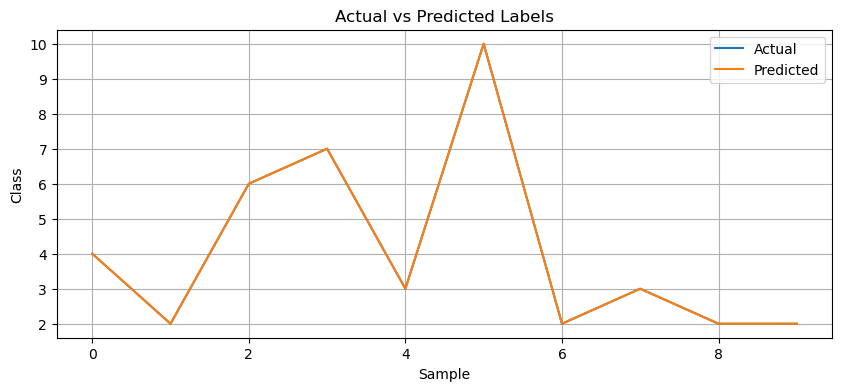

In [29]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 128
num_layers = 3
activation = nn.Sigmoid()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/100], Average Loss: 2.4202
Epoch [2/100], Average Loss: 2.1498
Epoch [3/100], Average Loss: 1.8407
Epoch [4/100], Average Loss: 1.6769
Epoch [5/100], Average Loss: 1.5101
Epoch [6/100], Average Loss: 1.4092
Epoch [7/100], Average Loss: 1.3531
Epoch [8/100], Average Loss: 1.3142
Epoch [9/100], Average Loss: 1.2865
Epoch [10/100], Average Loss: 1.2658
Epoch [11/100], Average Loss: 1.2388
Epoch [12/100], Average Loss: 1.2080
Epoch [13/100], Average Loss: 1.1810
Epoch [14/100], Average Loss: 1.1501
Epoch [15/100], Average Loss: 1.1245
Epoch [16/100], Average Loss: 1.1066
Epoch [17/100], Average Loss: 1.0842
Epoch [18/100], Average Loss: 1.0665
Epoch [19/100], Average Loss: 1.0518
Epoch [20/100], Average Loss: 1.0216
Epoch [21/100], Average Loss: 1.0020
Epoch [22/100], Average Loss: 0.9774
Epoch [23/100], Average Loss: 0.9552
Epoch [24/100], Average Loss: 0.9212
Epoch [25/100], Average Loss: 0.8970
Epoch [26/100], Average Loss: 0.8724
Epoch [27/100], Average Loss: 0.8499
Epoch [28/

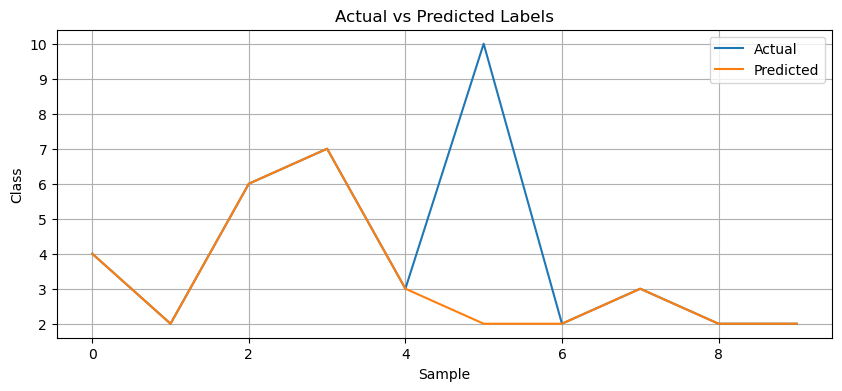

In [72]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 128
num_layers = 3
activation = nn.Sigmoid()
learning_rate = 0.001
epochs = 100

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

### Setting 6, Epochs = 100 for Layer = 4, hidden_layer = 256

Epoch [1/1000], Average Loss: 2.4311
Epoch [2/1000], Average Loss: 2.0077
Epoch [3/1000], Average Loss: 1.6099
Epoch [4/1000], Average Loss: 1.4028
Epoch [5/1000], Average Loss: 1.3255
Epoch [6/1000], Average Loss: 1.3041
Epoch [7/1000], Average Loss: 1.2794
Epoch [8/1000], Average Loss: 1.2650
Epoch [9/1000], Average Loss: 1.2552
Epoch [10/1000], Average Loss: 1.2378
Epoch [11/1000], Average Loss: 1.2267
Epoch [12/1000], Average Loss: 1.1953
Epoch [13/1000], Average Loss: 1.1851
Epoch [14/1000], Average Loss: 1.1418
Epoch [15/1000], Average Loss: 1.0976
Epoch [16/1000], Average Loss: 1.0045
Epoch [17/1000], Average Loss: 0.9360
Epoch [18/1000], Average Loss: 0.9000
Epoch [19/1000], Average Loss: 0.8552
Epoch [20/1000], Average Loss: 0.8144
Epoch [21/1000], Average Loss: 0.7853
Epoch [22/1000], Average Loss: 0.7607
Epoch [23/1000], Average Loss: 0.7517
Epoch [24/1000], Average Loss: 0.7508
Epoch [25/1000], Average Loss: 0.7318
Epoch [26/1000], Average Loss: 0.7137
Epoch [27/1000], Aver

Epoch [214/1000], Average Loss: 0.2538
Epoch [215/1000], Average Loss: 0.2754
Epoch [216/1000], Average Loss: 0.2497
Epoch [217/1000], Average Loss: 0.2464
Epoch [218/1000], Average Loss: 0.2571
Epoch [219/1000], Average Loss: 0.2797
Epoch [220/1000], Average Loss: 0.2867
Epoch [221/1000], Average Loss: 0.2562
Epoch [222/1000], Average Loss: 0.2666
Epoch [223/1000], Average Loss: 0.2718
Epoch [224/1000], Average Loss: 0.2537
Epoch [225/1000], Average Loss: 0.2457
Epoch [226/1000], Average Loss: 0.2609
Epoch [227/1000], Average Loss: 0.2630
Epoch [228/1000], Average Loss: 0.2699
Epoch [229/1000], Average Loss: 0.2716
Epoch [230/1000], Average Loss: 0.2761
Epoch [231/1000], Average Loss: 0.2610
Epoch [232/1000], Average Loss: 0.2725
Epoch [233/1000], Average Loss: 0.2498
Epoch [234/1000], Average Loss: 0.2447
Epoch [235/1000], Average Loss: 0.2343
Epoch [236/1000], Average Loss: 0.2489
Epoch [237/1000], Average Loss: 0.2466
Epoch [238/1000], Average Loss: 0.2686
Epoch [239/1000], Average

Epoch [425/1000], Average Loss: 0.1889
Epoch [426/1000], Average Loss: 0.1940
Epoch [427/1000], Average Loss: 0.2269
Epoch [428/1000], Average Loss: 0.2147
Epoch [429/1000], Average Loss: 0.1744
Epoch [430/1000], Average Loss: 0.1699
Epoch [431/1000], Average Loss: 0.1636
Epoch [432/1000], Average Loss: 0.1731
Epoch [433/1000], Average Loss: 0.1819
Epoch [434/1000], Average Loss: 0.1697
Epoch [435/1000], Average Loss: 0.1753
Epoch [436/1000], Average Loss: 0.1759
Epoch [437/1000], Average Loss: 0.1627
Epoch [438/1000], Average Loss: 0.1601
Epoch [439/1000], Average Loss: 0.1866
Epoch [440/1000], Average Loss: 0.1659
Epoch [441/1000], Average Loss: 0.1673
Epoch [442/1000], Average Loss: 0.1649
Epoch [443/1000], Average Loss: 0.1697
Epoch [444/1000], Average Loss: 0.1770
Epoch [445/1000], Average Loss: 0.1571
Epoch [446/1000], Average Loss: 0.1900
Epoch [447/1000], Average Loss: 0.1580
Epoch [448/1000], Average Loss: 0.1710
Epoch [449/1000], Average Loss: 0.1544
Epoch [450/1000], Average

Epoch [636/1000], Average Loss: 0.1296
Epoch [637/1000], Average Loss: 0.1161
Epoch [638/1000], Average Loss: 0.1113
Epoch [639/1000], Average Loss: 0.1187
Epoch [640/1000], Average Loss: 0.1367
Epoch [641/1000], Average Loss: 0.1139
Epoch [642/1000], Average Loss: 0.1038
Epoch [643/1000], Average Loss: 0.1205
Epoch [644/1000], Average Loss: 0.1111
Epoch [645/1000], Average Loss: 0.1091
Epoch [646/1000], Average Loss: 0.1058
Epoch [647/1000], Average Loss: 0.1079
Epoch [648/1000], Average Loss: 0.1295
Epoch [649/1000], Average Loss: 0.1233
Epoch [650/1000], Average Loss: 0.1030
Epoch [651/1000], Average Loss: 0.1388
Epoch [652/1000], Average Loss: 0.1195
Epoch [653/1000], Average Loss: 0.1187
Epoch [654/1000], Average Loss: 0.1750
Epoch [655/1000], Average Loss: 0.1403
Epoch [656/1000], Average Loss: 0.1019
Epoch [657/1000], Average Loss: 0.1085
Epoch [658/1000], Average Loss: 0.1048
Epoch [659/1000], Average Loss: 0.1005
Epoch [660/1000], Average Loss: 0.1037
Epoch [661/1000], Average

Epoch [847/1000], Average Loss: 0.1452
Epoch [848/1000], Average Loss: 0.0960
Epoch [849/1000], Average Loss: 0.0825
Epoch [850/1000], Average Loss: 0.0681
Epoch [851/1000], Average Loss: 0.0709
Epoch [852/1000], Average Loss: 0.0647
Epoch [853/1000], Average Loss: 0.0753
Epoch [854/1000], Average Loss: 0.0793
Epoch [855/1000], Average Loss: 0.0873
Epoch [856/1000], Average Loss: 0.0784
Epoch [857/1000], Average Loss: 0.0830
Epoch [858/1000], Average Loss: 0.1167
Epoch [859/1000], Average Loss: 0.1060
Epoch [860/1000], Average Loss: 0.1108
Epoch [861/1000], Average Loss: 0.1141
Epoch [862/1000], Average Loss: 0.0892
Epoch [863/1000], Average Loss: 0.0869
Epoch [864/1000], Average Loss: 0.0986
Epoch [865/1000], Average Loss: 0.0774
Epoch [866/1000], Average Loss: 0.0764
Epoch [867/1000], Average Loss: 0.0703
Epoch [868/1000], Average Loss: 0.0700
Epoch [869/1000], Average Loss: 0.0669
Epoch [870/1000], Average Loss: 0.0753
Epoch [871/1000], Average Loss: 0.0670
Epoch [872/1000], Average

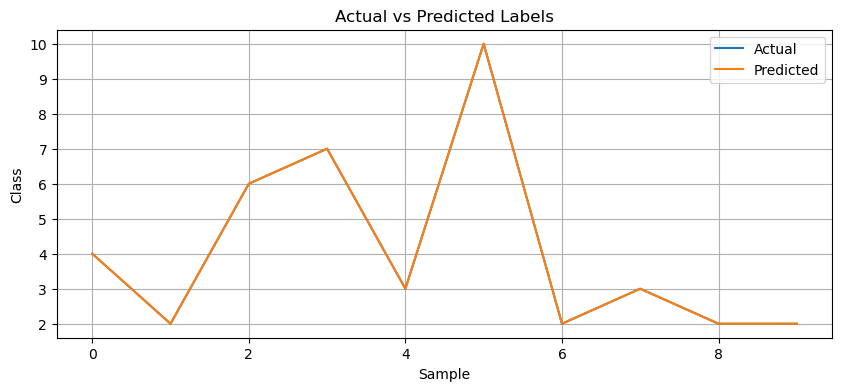

In [30]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 256
num_layers = 4
activation = nn.Sigmoid()
learning_rate = 0.001
epochs = 1000

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

Epoch [1/1000], Average Loss: 2.1274
Epoch [2/1000], Average Loss: 1.3933
Epoch [3/1000], Average Loss: 1.2932
Epoch [4/1000], Average Loss: 1.2016
Epoch [5/1000], Average Loss: 1.0423
Epoch [6/1000], Average Loss: 0.9380
Epoch [7/1000], Average Loss: 0.8421
Epoch [8/1000], Average Loss: 0.8198
Epoch [9/1000], Average Loss: 0.8839
Epoch [10/1000], Average Loss: 0.8460
Epoch [11/1000], Average Loss: 0.7983
Epoch [12/1000], Average Loss: 0.7798
Epoch [13/1000], Average Loss: 0.7477
Epoch [14/1000], Average Loss: 0.7542
Epoch [15/1000], Average Loss: 0.7401
Epoch [16/1000], Average Loss: 0.8436
Epoch [17/1000], Average Loss: 0.7388
Epoch [18/1000], Average Loss: 0.7254
Epoch [19/1000], Average Loss: 0.7443
Epoch [20/1000], Average Loss: 0.7049
Epoch [21/1000], Average Loss: 0.6995
Epoch [22/1000], Average Loss: 0.7073
Epoch [23/1000], Average Loss: 0.6854
Epoch [24/1000], Average Loss: 0.6466
Epoch [25/1000], Average Loss: 0.6601
Epoch [26/1000], Average Loss: 0.6438
Epoch [27/1000], Aver

Epoch [214/1000], Average Loss: 0.2948
Epoch [215/1000], Average Loss: 0.2587
Epoch [216/1000], Average Loss: 0.2712
Epoch [217/1000], Average Loss: 0.3018
Epoch [218/1000], Average Loss: 0.2343
Epoch [219/1000], Average Loss: 0.2329
Epoch [220/1000], Average Loss: 0.2818
Epoch [221/1000], Average Loss: 0.2907
Epoch [222/1000], Average Loss: 0.2562
Epoch [223/1000], Average Loss: 0.2431
Epoch [224/1000], Average Loss: 0.2462
Epoch [225/1000], Average Loss: 0.2672
Epoch [226/1000], Average Loss: 0.2758
Epoch [227/1000], Average Loss: 0.2553
Epoch [228/1000], Average Loss: 0.3059
Epoch [229/1000], Average Loss: 0.2512
Epoch [230/1000], Average Loss: 0.2591
Epoch [231/1000], Average Loss: 0.2360
Epoch [232/1000], Average Loss: 0.2666
Epoch [233/1000], Average Loss: 0.2934
Epoch [234/1000], Average Loss: 0.2421
Epoch [235/1000], Average Loss: 0.2578
Epoch [236/1000], Average Loss: 0.2465
Epoch [237/1000], Average Loss: 0.2932
Epoch [238/1000], Average Loss: 0.2898
Epoch [239/1000], Average

Epoch [425/1000], Average Loss: 0.2371
Epoch [426/1000], Average Loss: 0.2181
Epoch [427/1000], Average Loss: 0.2518
Epoch [428/1000], Average Loss: 0.3097
Epoch [429/1000], Average Loss: 0.3279
Epoch [430/1000], Average Loss: 0.2672
Epoch [431/1000], Average Loss: 0.2409
Epoch [432/1000], Average Loss: 0.2410
Epoch [433/1000], Average Loss: 0.2356
Epoch [434/1000], Average Loss: 0.2416
Epoch [435/1000], Average Loss: 0.2215
Epoch [436/1000], Average Loss: 0.3578
Epoch [437/1000], Average Loss: 0.3306
Epoch [438/1000], Average Loss: 0.2434
Epoch [439/1000], Average Loss: 0.2804
Epoch [440/1000], Average Loss: 0.2384
Epoch [441/1000], Average Loss: 0.2396
Epoch [442/1000], Average Loss: 0.2270
Epoch [443/1000], Average Loss: 0.3121
Epoch [444/1000], Average Loss: 0.2698
Epoch [445/1000], Average Loss: 0.2256
Epoch [446/1000], Average Loss: 0.2482
Epoch [447/1000], Average Loss: 0.2227
Epoch [448/1000], Average Loss: 0.2173
Epoch [449/1000], Average Loss: 0.2482
Epoch [450/1000], Average

Epoch [636/1000], Average Loss: 0.3434
Epoch [637/1000], Average Loss: 0.2543
Epoch [638/1000], Average Loss: 0.2410
Epoch [639/1000], Average Loss: 0.2922
Epoch [640/1000], Average Loss: 0.2504
Epoch [641/1000], Average Loss: 0.2502
Epoch [642/1000], Average Loss: 0.2416
Epoch [643/1000], Average Loss: 0.2983
Epoch [644/1000], Average Loss: 0.2486
Epoch [645/1000], Average Loss: 0.2887
Epoch [646/1000], Average Loss: 0.2840
Epoch [647/1000], Average Loss: 0.2269
Epoch [648/1000], Average Loss: 0.2725
Epoch [649/1000], Average Loss: 0.2759
Epoch [650/1000], Average Loss: 0.2716
Epoch [651/1000], Average Loss: 0.2846
Epoch [652/1000], Average Loss: 0.2464
Epoch [653/1000], Average Loss: 0.2391
Epoch [654/1000], Average Loss: 0.2339
Epoch [655/1000], Average Loss: 0.2174
Epoch [656/1000], Average Loss: 0.2623
Epoch [657/1000], Average Loss: 0.2518
Epoch [658/1000], Average Loss: 0.2457
Epoch [659/1000], Average Loss: 0.2643
Epoch [660/1000], Average Loss: 0.3053
Epoch [661/1000], Average

Epoch [847/1000], Average Loss: 0.2501
Epoch [848/1000], Average Loss: 0.2532
Epoch [849/1000], Average Loss: 0.2583
Epoch [850/1000], Average Loss: 0.2736
Epoch [851/1000], Average Loss: 0.2838
Epoch [852/1000], Average Loss: 0.2931
Epoch [853/1000], Average Loss: 0.2790
Epoch [854/1000], Average Loss: 0.2757
Epoch [855/1000], Average Loss: 0.3131
Epoch [856/1000], Average Loss: 0.3118
Epoch [857/1000], Average Loss: 0.2995
Epoch [858/1000], Average Loss: 0.2948
Epoch [859/1000], Average Loss: 0.3066
Epoch [860/1000], Average Loss: 0.2873
Epoch [861/1000], Average Loss: 0.2998
Epoch [862/1000], Average Loss: 0.2914
Epoch [863/1000], Average Loss: 0.2562
Epoch [864/1000], Average Loss: 0.2413
Epoch [865/1000], Average Loss: 0.2398
Epoch [866/1000], Average Loss: 0.2214
Epoch [867/1000], Average Loss: 0.3092
Epoch [868/1000], Average Loss: 0.2979
Epoch [869/1000], Average Loss: 0.2646
Epoch [870/1000], Average Loss: 0.2494
Epoch [871/1000], Average Loss: 0.2840
Epoch [872/1000], Average

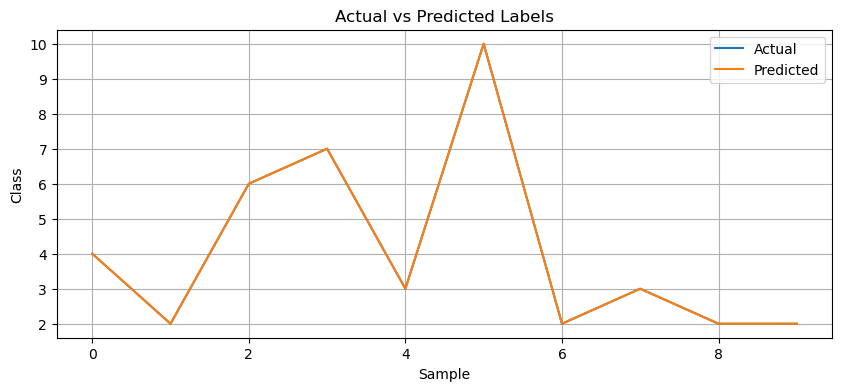

In [75]:
# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=42)

# Defining hyperparameters #Setting 1
hidden_size = 256
num_layers = 4
activation = nn.Sigmoid()
learning_rate = 0.01
epochs = 1000

# Training the model
train_model(X_train, y_train, X_test, y_test, hidden_size, num_layers, activation, learning_rate, epochs)

# Exploring Hyperspectral Dataset

# $Kennedy Space Centre Dataset$

In [10]:
## Kennedy space center dataset
# downloaded from :
#https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes

In [11]:
#importing the dataset
ksc_data = loadmat('KSC_corrected.mat')['KSC']
print('Data shape:', ksc_data.shape)
ksc_gt = loadmat('KSC_gt.mat')['KSC_gt']
print('Ground Truth shape:', ksc_gt.shape)

Data shape: (512, 614, 176)
Ground Truth shape: (512, 614)


In [12]:
##Converting into dataframe
ksc_df = pd.DataFrame(ksc_data.reshape(ksc_data.shape[0]*ksc_data.shape[1], -1))
ksc_df.columns = [f'band{i}' for i in range(1, ksc_df.shape[-1]+1)]
ksc_df['class'] = ksc_gt.ravel()

ksc_df.head()

band1  band2  band3  band4  band5  band6  band7  band8  band9  band10  ...  \
0     11     26     19     16     20     25     27     33     36      39  ...   
1      4     22     10      7     11     14     19     24     25      29  ...   
2      6     16      9      7     12     15     16     22     24      26  ...   
3     19     33     21     18     24     26     30     37     39      44  ...   
4     17     39     31     28     35     39     41     49     52      55  ...   

   band168  band169  band170  band171  band172  band173  band174  band175  \
0       75       75       74       70       74       63       63       64   
1       47       45       54       44       47       47       38       44   
2       56       70       59       59       63       59       48       47   
3      116      116      122      117      115      116      103      113   
4      165      167      169      156      158      154      147      140   

   band176  class  
0       58      0  
1       43      0  
2       49      0  
3       89      0  
4      123      0  

[5 rows x 177 columns]

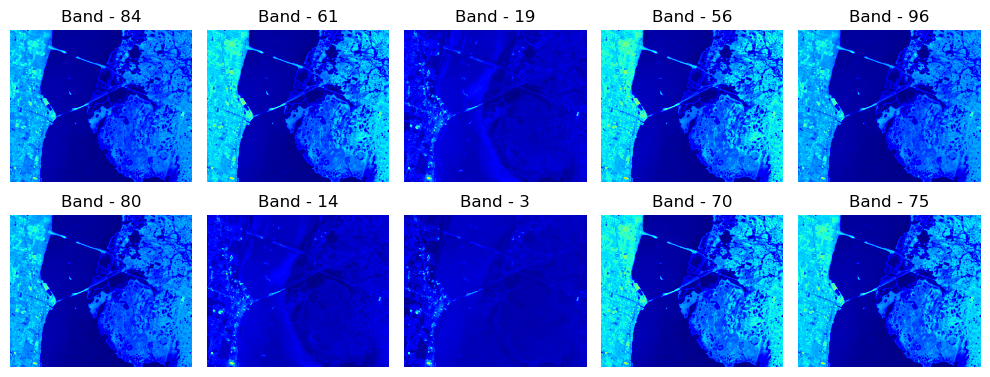

In [13]:
#Visualizing the data
fig = plt.figure(figsize = (10, 4))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(ksc_data[:, :, c], cmap='jet')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1
   
plt.tight_layout()
plt.show()

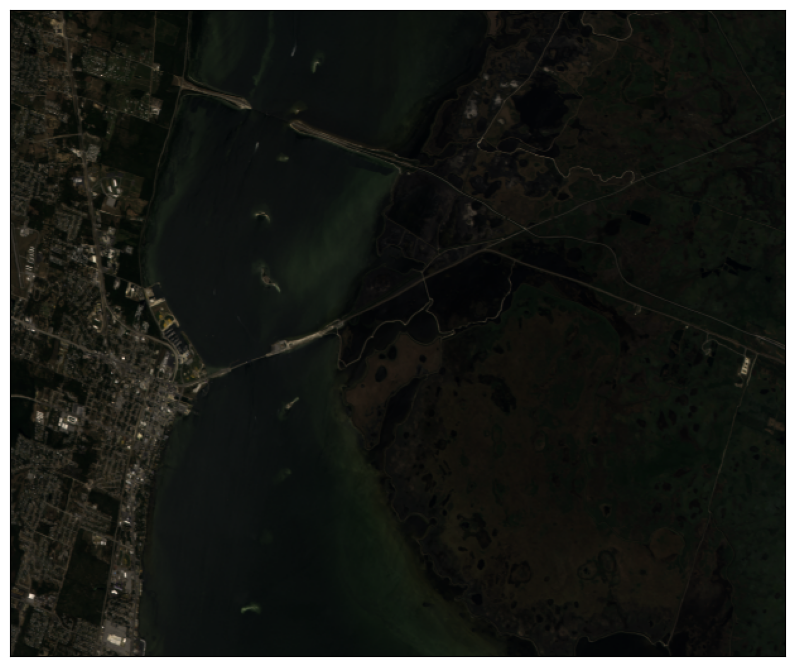

In [14]:
## RGB composite
import earthpy.plot as ep

mdata = np.moveaxis(ksc_data, -1, 0)
ep.plot_rgb(mdata, (29, 19, 9), figsize=(10,10))
plt.show()

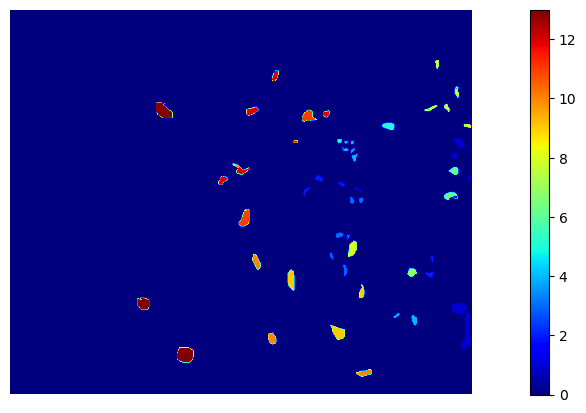

In [15]:
## plotting the ground truth
def plot_data(data):
    fig = plt.figure(figsize = (15, 5))
    plt.imshow(data, cmap = 'jet')
    plt.colorbar()
    plt.axis('off')
    plt.show()
plot_data(ksc_gt)

In [16]:
class_values = ksc_df['class'].unique()  # Get unique class labels

# Dictionary to store DataFrame for each class
class_data = {}

for class_label in class_values:
    # Filter DataFrame for each class
    class_df = ksc_df[ksc_df['class'] == class_label]
    class_data[class_label] = class_df

# class_data dictionary contains DataFrames for each class
class_values

array([ 0,  8, 12, 13, 11,  5,  1,  4,  6,  2,  3, 10,  7,  9],
      dtype=uint8)

In [17]:
class_name = ['Oak Hammock', 'Mud Flats', 'Spartina Marsh', 'Salt Marsh',
              'Scrub', 'CP/Oak Hammock', 'CP Hammock', 'Typha Marsh', 'Willow Swamp',
              'Hardwood Swamp', 'Graminoid Marsh', 'Slash Pine', 'Water Body']

# Create a dictionary to store DataFrames with class names as keys
class_data_named = {class_name[i]: class_data[i + 1] for i in range(len(class_name))}

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(class_data_named.values())

In [18]:
class_data_named

{'Oak Hammock':         band1  band2  band3  band4  band5  band6  band7  band8  band9  band10  \
 106198     19     36     26     23     27     27     30     35     34      37   
 106199     21     36     25     24     28     28     30     33     35      36   
 106200     19     37     29     24     26     28     30     35     35      37   
 106201     21     30     26     22     26     28     30     33     33      37   
 106202     19     35     28     23     27     28     28     33     35      36   
 ...       ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
 277516     24     36     29     28     31     31     33     39     39      40   
 277517     24     40     32     26     30     32     34     38     40      42   
 277518     24     37     32     25     29     30     33     37     39      39   
 277519     28     43     28     28     31     33     36     38     40      41   
 278128     24     42     34     24     31     33     35     38     40      41   
 

In [19]:
# Define colors for each class
class_colors = {
    'Oak Hammock': 'red',
    'Mud Flats': 'brown',
    'Spartina Marsh': 'black',
    'Salt Marsh': 'orange',
    'Scrub': 'purple',
    'CP/Oak Hammock': 'green',
    'CP Hammock': 'pink',
    'Typha Marsh': 'gray',
    'Willow Swamp': 'cyan',
    'Hardwood Swamp': 'magenta',
    'Graminoid Marsh': 'yellow',
    'Slash Pine': 'violet',
    'Water Body': 'blue',
}

In [20]:
# Function to handle plot generation
def plot_selected_classes(button):
    plt.figure(figsize=(14, 6))
    plotted = False
    num_rows_to_plot = int(rows_slider.value)
    for checkbox_row in checkbox_rows:
        for checkbox in checkbox_row.children:
            if checkbox.value:
                class_name = checkbox.description
                class_df = class_data_named[class_name]
                x_values = class_df.iloc[0, 1:].index
                for selected_row in range(num_rows_to_plot):
                    if selected_row <= class_df.shape[0]:
                        plt.plot(x_values, class_df.iloc[selected_row, 1:], label=f'{class_name}_row_{selected_row+1}', color=class_colors[class_name])
                        plt.xlim(0, len(class_df.columns[:-1]))
                        ticks = np.arange(0, len(class_df.columns[:-1]), 45)
                        plotted = True
                    else:
                        print(f"Row {selected_row} does not exist in {class_name}.")
    if plotted:
        plt.title(f'Spectral classes')
        plt.xlabel('Band')
        plt.xticks(ticks)
        plt.ylabel('Pixel Value')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True)
        plt.show()
    else:
        print("No classes selected.")

In [21]:
# Split class names into groups for arranging in rows
class_names = list(class_data_named.keys())
num_rows = 4
class_checkboxes_groups = [class_names[i::num_rows] for i in range(num_rows)]

In [22]:
# Create HBox for each row of checkboxes
checkbox_rows = [widgets.HBox([widgets.Checkbox(description=class_name, value=True) for class_name in group]) for group in class_checkboxes_groups]

# Arrange rows vertically
checkbox_layout = widgets.VBox(checkbox_rows)

In [23]:
# Display checkboxes
display(checkbox_layout)

# Dropdown to select row number
rows_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    description='Rows to Plot:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Display rows slider
display(rows_slider)



# Create a button to update the plot
update_button = widgets.Button(description='Update Plot')
update_button.on_click(plot_selected_classes)

# Display the button
display(update_button)


IntSlider(value=1, continuous_update=False, description='Rows to Plot:', max=20, min=1)

Button(description='Update Plot', style=ButtonStyle())

#  $$Thank You $$